In [1]:
import pandas as pd
from pathlib import Path
import os, re, json, argparse, sys
import rdkit

In [3]:

VOCAB_SEED_DEFAULT = {
    # "Ac": "CC(=O)",
    # "Gly": "NCC(=O)O",
    # "Ala":"NC(C)C(=O)O",
    # "Ser":"NCC(O)C(=O)O",
    # "Thr":"NC(CO)C(=O)O",
    # "Tyr":"NC(C1=CC=CC=C1O)C(=O)O",
    # "Lys":"NC(CCCCN)C(=O)O",
    # "Arg":"NC(CCCNC(N)=N)C(=O)O","Asp":"NCC(=O)OC(=O)O",
    # "Glu":"NCCC(=O)OC(=O)O",
    # "Cys":"NCC(S)C(=O)O","Met":"NCC(SCC)C(=O)O",
    # "Pro":"N1CCCC1C(=O)O","Phe":"NC(CC1=CC=CC=C1)C(=O)O",
    # "Trp":"NC(CC1=CNC2=CC=CC=C12)C(=O)O",
    # "His":"NC(CC1=CN=CN1)C(=O)O",
    # "Asn":"NCC(=O)NC(=O)O",
    # "Gln":"NCCC(=O)NC(=O)O",
    # "Ile":"NC(C(CC)C)C(=O)O",
    # "Leu":"NC(CC(C)C)C(=O)O",
    # "Val":"NC(C(C)C)C(=O)O",
    # single letter codes STANDARD AMINO ACIDS
    "A":"NC(C)C(=O)O",
    "R":"NC(CCCNC(N)=N)C(=O)O",
    "N":"NCC(=O)NC(=O)O",
    "D":"NCC(=O)OC(=O)O",
    "C":"NCC(S)C(=O)O",
    "E":"NCCC(=O)OC(=O)O",
    "Q":"NCCC(=O)NC(=O)O",
    "G":"NCC(=O)O",
    "H":"NC(CC1=CN=CN1)C(=O)O",
    "I":"NC(C(CC)C)C(=O)O",
    "L":"NC(CC(C)C)C(=O)O",
    "K":"NC(CCCCN)C(=O)O",
    "M":"NCC(SCC)C(=O)O",
    "F":"NC(CC1=CC=CC=C1)C(=O)O",
    "P":"N1CCCC1C(=O)O",
    "S":"NCC(O)C(=O)O",
    "T":"NC(CO)C(=O)O",
    "W":"NC(CC1=CNC2=CC=CC=C12)C(=O)O",
    "Y":"NC(C1=CC=CC=C1O)C(=O)O",
    "V":"NC(C(C)C)C(=O)O",
    # phosphorylated amino acids
    "pSer":"NCC(OP(=O)(O)O)C(=O)O",
    "pThr":"NC(COP(=O)(O)O)C(=O)O",
    "pTyr":"NC(C1=CC=C(O-P(=O)(O)O)C=C1)C(=O)O"
}


In [4]:
def standardize_seqref(m):
    num = m.group(1)
    return f"(SEQ ID NO:{num})"

# def tokenize_seq(seq: str):
#     if not isinstance(seq, str):
#         return []
#     s = seq.replace("–","-").replace("—","-")
#     pieces = [p.strip() for p in s.split("-") if p.strip()]
#     out = []
#     for p in pieces:
#         m = SEQ_REF_RE.search(p)
#         seqref = ""
#         if m:
#             seqref = standardize_seqref(m)
#             p = SEQ_REF_RE.sub(" ", p, count=1)
#         token = p.strip()
#         if not token or token.upper().startswith("SEQ ID NO"):
#             continue
#         out.append((token, seqref))
#     return out

def load_frame(path: Path) -> pd.DataFrame:
    ext = path.suffix.lower()
    if ext in (".xlsx",".xls"):
        return pd.read_excel(path)
    if ext in (".csv",".tsv"):
        sep = "," if ext == ".csv" else "\t"
        return pd.read_csv(path, sep=sep)
    raise ValueError(f"Unsupported file type: {ext}")

def find_seq_col(df: pd.DataFrame, preferred: str = None) -> str:
    if preferred and preferred in df.columns:
        return preferred
    for c in df.columns:
        cl = str(c).lower()
        if "seq" in cl and "id" in cl:
            return c
    if "SEQ_ID" in df.columns:
        return "SEQ_ID"
    raise KeyError("SEQ_ID column not found. Use --seq-col to specify.")

SEQ_REF_RE = re.compile(r"[\(（]\s*SEQ[\s\S]*?ID[\s\S]*?NO\s*[:：]\s*(?:\d+.*+)\s*[\)）]", re.IGNORECASE)
# SEQ_REF_RE = re.compile(r'SEQ[\s\S]*?ID[\s\S]*?NO\s*[:：]\s*(?:\d\s*+)\s*[\)\uFF09]',re.IGNORECASE)
# SEQ_REF_RE = re.compile(
#     r'SEQ[\s\S]*?ID[\s\S]*?NO\s*[:：]\s*((?:\d\s*)+)\s*[\)\uFF09]',
#     re.IGNORECASE
# )
SEQ_ANY_RE = re.compile(r'[（(]\s*SEQ\b[^）)]*[)）]', re.IGNORECASE)


def split_and_clean(seq: str):
    if not isinstance(seq, str):
        return []
    s = seq.replace("–", "-").replace("—", "-")
    toks = []
    for p in s.split("-"):
        p = p.strip()
        if not p:
            continue
        p = SEQ_ANY_RE.sub("", p).strip()#re.findall(SEQ_REF_RE, seq)
        if p:
            toks.append(p)
    return toks

In [5]:
#clean smiles normal
# C)C(=; O)N([H])[
t='[H]N([C@@H](CCCCN(C)C)C(N)=O)C(=O)[C@H](CCCCNC(=O)CCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCC(=O)NCCCC[C@H](NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(C)=O)[C@@H](C)CC)[C@@H](C)O)C(C)C)[C@@H](C)O)[C@@H](C)CC)[C@@H](C)CC)C(=; O)N([H])[C@@H](CCCCN(C)C)C(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(C)=O)[C@@H](C)CC)[C@@H](C)O)C(C)C)[C@@H](C)O)[C@@H](C)CC)[C@@H](C)CC'
t = t.replace('（', '(').replace('）', ')').replace('【', '[').replace('】', ']')
t =t.replace('；', '').replace('，', '').replace(';', '').replace(',', '').replace(' ', '')
t

'[H]N([C@@H](CCCCN(C)C)C(N)=O)C(=O)[C@H](CCCCNC(=O)CCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCC(=O)NCCCC[C@H](NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(C)=O)[C@@H](C)CC)[C@@H](C)O)C(C)C)[C@@H](C)O)[C@@H](C)CC)[C@@H](C)CC)C(=O)N([H])[C@@H](CCCCN(C)C)C(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(C)=O)[C@@H](C)CC)[C@@H](C)O)C(C)C)[C@@H](C)O)[C@@H](C)CC)[C@@H](C)CC'

In [210]:
# seq_col="SEQ_ID"
# seq_list = find_seq_col(df, "SEQ_ID")
# seq_list=['ac-I-H-V-T-I-P-A-D-L-W-D-W-I-N-K-am(SEQ:IDNO:1)',
#  'ac-I-T-V-T-I-P-A-D-L-W-D-W-I-K-LyS_Dimethyl-am (SEQ ID NO:2)',
#  'ac-I-T-V-T-I-P-A-D-L-W-D-W-I-K-LyS_Dimethyl-am (SEQ ID NO:2)ac-I-T-V-T-I-P-A-D-L-W-I-K-LyS_Dimethyl-C-D-am(SEQ ID NO:2)']


in_path=Path("/cadd_data/cw/works/pys/RapidTable-main/pp5table_out/IL17_PTX2025_2025_10_21_17_57_55.xlsx")
df = load_frame(in_path)
seq_list=df["SEQ_ID"].dropna().astype(str)
vocabs = set()
for seq in seq_list:
    for tok in split_and_clean(seq):
        vocabs.add(tok)
vocab_sorted = sorted(vocabs, key=str)


#re Remove smt
cleaned_vocab_sorted = [re.sub(r'(?im)^.*first.*$', '', text, flags=re.IGNORECASE) for text in vocab_sorted]
cleaned_vocab_sorted={re.sub(r'(?im)^.*Note.*$', '', text, flags=re.IGNORECASE) for text in cleaned_vocab_sorted}
cleaned_vocab_sorted={re.sub(r'__', '_', text) for text in cleaned_vocab_sorted}
cleaned_vocab_sorted={re.sub(r' _', '_', text) for text in cleaned_vocab_sorted}
pattern = re.compile(r'isovaleric acid', re.IGNORECASE)
pattern2 = re.compile(r'GlutariC_ACid', re.IGNORECASE)
cleaned_vocab_sorted = {pattern.sub('Isoaleric Acid', text) 
                        for text in cleaned_vocab_sorted}
cleaned_vocab_sorted = {pattern2.sub('Isoaleric Acid', text) 
                        for text in cleaned_vocab_sorted}
remove_set = {
    'aC', 'ac', 
    'am',
    'am aC',
    'am n','',
 ')','am n  aC',
    'am(','',
    'am(SEQ ID NO:130',
    'am1 1', 'dR [H]NC(N)=NCCCC(NC(=O)C(CCCCNC(=O)CCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCC(=O)NCCCCC (NC(=O)C1CCCSSCCCC(NC(=O)C([H])(NC(=O)C(CC2=CC=C(C=C2)C(F)(F)F)NC(=O)C(CCO[H])NC(=O)C([H])(NC(C)=O)C(C)CC)C(C )O[H])C(=O)N2C3CCCCC3CC2C(=O)NC(C)C(=O)NC(CC(O)=O)C(=O)NC(CCCCCCCC)C(=O)NC(CC2=CN([H])C3=C2C=CC=C3)C(=O)NC(CC (O)=O)C(=O)NC(CC2=CN([H])C3=C2C=CC=C3)C(=O)N1)C(=O)NC(CCCN=C(N)N[H])C(N)=O)NC(=O)C1CCCSSCCCC(NC(=O)C([H])(NC( =O)C(CC2=CC=C(C=C2)C(F)(F)F)NC(=O)C(CCO[H])NC(=O)C([H])(NC(C)=O)C(C)CC)C(C)O[H])C(=O)N2C3CCCCC3CC2C(=O)NC(C)C (=O)NC(CC(O)=O)C(=O)NC(CCCCCCCC)C(=O)NC(CC2=CN([H])C3=C2C=CC=C3)C(=O)NC(CC(O)=O)C(=O)NC(CC2=CN([H])C3=C2C=CC= C3)C(=O)N1)C(N)=O',

}#NOTE hard codes
for vocab in remove_set:
    cleaned_vocab_sorted.discard(vocab)
# _    __
cleaned_vocab_sorted    

{'1Nal',
 '1PEG21PEG2ISOGluC12',
 '1PEG21PEG2IsoGluPalm',
 '1PEG2_1PEG2_ISoGlu_C12',
 '2Nal',
 '2Pal',
 '3Hydroxypropionicacid',
 '3Pal',
 '4RBenzyloxyPro',
 '4RPhePro',
 '4SCF3Pro',
 '4SCyclohexPro',
 'A',
 'AOC',
 'Aad',
 'Abu',
 'Acvc',
 'AdamantylGly',
 'Aib',
 'AlaCF3',
 'AlaCHF2',
 'Ala_CyCBu',
 'Ala_CycBu',
 'AoC',
 'Aoc',
 'Aph',
 'AzetidinOne',
 'Azetidinone',
 'C',
 'C6_Diacid',
 'Cha',
 'Chg',
 'Cit',
 'Cpg',
 'CyclopropanecarboxylicAcid',
 'Cyclopropyl_Ala',
 'D',
 'Dab',
 'Dab2HyAC',
 'DabMs',
 'DabTs',
 'Dab_AC',
 'Dab_ACetyl',
 'Dab_Acetyl',
 'Dfp',
 'Dg1',
 'Dgl',
 'Dql',
 'E',
 'EtOMe',
 'G',
 'Gla',
 'Glu_OMe',
 'GlycolicAcid',
 'H',
 'HCy',
 'H_Cha',
 'Hcy',
 'Hcy(1:R3)',
 'Hcy(2:R3)',
 'HhC',
 'HhF',
 'Hhc',
 'Hhc(1:R3)',
 'Hph',
 'Hpr',
 'Hse',
 'I',
 'ISOValeriC_ACid',
 'ISOValeriC_Acid',
 'ISOvaleriC_ACid',
 'ISOvaleric_Acid',
 'Igl',
 'IsOValeriC_ACid',
 'IsOValeriC_Acid',
 'IsOvaleriC_Acid',
 'IsOvaleriC_acid',
 'IsOvaleric_Acid',
 'IsoGlu',
 'IsoValeriC_Acid',

In [211]:
seed_vocabs=set(VOCAB_SEED_DEFAULT.keys())
print(len(cleaned_vocab_sorted),len(seed_vocabs))

232 23


In [212]:
intersection_set = seed_vocabs.intersection(cleaned_vocab_sorted)
# 使用集合运算一次性获取所有结果
seed_only = seed_vocabs - cleaned_vocab_sorted
cleaned_only = cleaned_vocab_sorted - seed_vocabs
intersection = seed_vocabs & cleaned_vocab_sorted
print(f"seed_vocabs 独有: {len(seed_only)}")
print(f"cleaned_vocab_sorted 独有: {len(cleaned_only)}")
print(f"交集: {len(intersection)}")

seed_vocabs 独有: 6
cleaned_vocab_sorted 独有: 215
交集: 17


In [213]:
unio = seed_vocabs | cleaned_vocab_sorted
len(unio)

238

In [214]:
sorted_cleaned_only=sorted(list(cleaned_only))
len(cleaned_vocab_sorted),sorted_cleaned_only

(232,
 ['1Nal',
  '1PEG21PEG2ISOGluC12',
  '1PEG21PEG2IsoGluPalm',
  '1PEG2_1PEG2_ISoGlu_C12',
  '2Nal',
  '2Pal',
  '3Hydroxypropionicacid',
  '3Pal',
  '4RBenzyloxyPro',
  '4RPhePro',
  '4SCF3Pro',
  '4SCyclohexPro',
  'AOC',
  'Aad',
  'Abu',
  'Acvc',
  'AdamantylGly',
  'Aib',
  'AlaCF3',
  'AlaCHF2',
  'Ala_CyCBu',
  'Ala_CycBu',
  'AoC',
  'Aoc',
  'Aph',
  'AzetidinOne',
  'Azetidinone',
  'C6_Diacid',
  'Cha',
  'Chg',
  'Cit',
  'Cpg',
  'CyclopropanecarboxylicAcid',
  'Cyclopropyl_Ala',
  'Dab',
  'Dab2HyAC',
  'DabMs',
  'DabTs',
  'Dab_AC',
  'Dab_ACetyl',
  'Dab_Acetyl',
  'Dfp',
  'Dg1',
  'Dgl',
  'Dql',
  'EtOMe',
  'Gla',
  'Glu_OMe',
  'GlycolicAcid',
  'HCy',
  'H_Cha',
  'Hcy',
  'Hcy(1:R3)',
  'Hcy(2:R3)',
  'HhC',
  'HhF',
  'Hhc',
  'Hhc(1:R3)',
  'Hph',
  'Hpr',
  'Hse',
  'ISOValeriC_ACid',
  'ISOValeriC_Acid',
  'ISOvaleriC_ACid',
  'ISOvaleric_Acid',
  'Igl',
  'IsOValeriC_ACid',
  'IsOValeriC_Acid',
  'IsOvaleriC_Acid',
  'IsOvaleriC_acid',
  'IsOvaleric_Ac

In [ ]:
# -*- coding: utf-8 -*-
"""
Sequence -> SMILES
- 支持 ac / am 端基
- 支持 D 构型（库内给 D 版本；或自动反转 α-碳手性）
- 支持非天然残基（由你的 monomer 库提供模板）

序列格式示例：
  "ac-Tle-I-H-Tle-T-Hcy-OiC-A-D-Ogl-2Nal-D-W-HCy-N-dR-am"
规则：
  - 用 '-' 分隔
  - 单独的 'D' / 'd' 令“下一个残基”为 D 构型
  - 'dX'（如 dR）视为该残基的 D 构型；若库无 dR 条目，则用 R 并反转手性

monomer 库 JSON 格式（示例见文末）：
[
  {
    "code": "A",
    "aliases": ["Ala"],
    "type": "PEPTIDE",
    "smiles_L": "[*:1]N[C@@H](C)C(=O)[*:2]",
    "smiles_D": "[*:1]N[C@H](C)C(=O)[*:2]"  # 可选；若缺省则自动反转
  },
  {
    "code": "ac",
    "type": "CAP_N",
    "smiles": "C(=O)C([*:2])"
  },
  {
    "code": "am",
    "type": "CAP_C",
    "smiles": "N([*:1])"
  },
  ...
]
"""

from rdkit import Chem
from rdkit.Chem import AllChem
import json, argparse, re
from typing import Dict, Tuple, List, Optional

# -------------------------
# 工具函数：锚点与手性处理
# -------------------------
def _anchor_neighbors(mol: Chem.Mol) -> Tuple[Dict[int, int], List[int]]:
    """
    读取 'HELM corelib' 风格的锚点：例如 N[H:1]、C(=O)[OH:2]、S[H:3]
    返回：
      anchors: { map_num -> anchor_heavy_atom_idx }
               （如 {1: idx_of_N, 2: idx_of_carbonyl_C, 3: idx_of_S}）
      leaving_atoms: [atom_idx, ...]  # 需要在组装完成后移除的“离去原子”（H 或 OH 中的 O）
    规则：
      - 若带 map 的是 H（[H:n]）：锚点是它唯一的重原子邻居；离去原子是这个 H 本身。
      - 若带 map 的是 O（[OH:n]）：锚点是它唯一的重原子邻居（常见：羰基碳 C）；离去原子是这个 O 本身。
      - 其他重原子（如 [Cl:n]、[Br:n]）同理：锚点=它唯一的重原子邻居；离去原子=该重原子。
    注意：
      - 要求“离去原子”应当只有 1 个重原子邻居；否则抛错提示模板需更具体。
    """
    anchors: Dict[int, int] = {}
    leaving_atoms: List[int] = []

    for a in mol.GetAtoms():
        amap = a.GetAtomMapNum()
        if amap <= 0:
            continue  # 只看带 map 的原子

        # 找该“带 map 的离去原子”的重原子邻居
        heavy_nbrs = [nb for nb in a.GetNeighbors() if nb.GetAtomicNum() > 1]
        if len(heavy_nbrs) != 1:
            raise ValueError(
                f"带 AtomMapNum={amap} 的离去原子应恰有 1 个重原子邻居；"
                f"当前有 {len(heavy_nbrs)} 个，请检查模板：idx={a.GetIdx()}, symbol={a.GetSymbol()}"
            )

        anchor_heavy = heavy_nbrs[0]
        anchors[amap] = anchor_heavy.GetIdx()
        leaving_atoms.append(a.GetIdx())

    if not anchors:
        raise ValueError("未在分子中发现任何 AtomMapNum（如 [H:1] / [OH:2] / [H:3]）；请确认模板是否为 HELM corelib 风格。")

    return anchors, leaving_atoms


def _remove_all_dummies(rwm: Chem.RWMol):
    to_del = [a.GetIdx() for a in rwm.GetAtoms() if a.GetAtomicNum()==0]
    for idx in sorted(to_del, reverse=True):
        rwm.RemoveAtom(idx)

def _find_alpha_carbon_idx(mol: Chem.Mol) -> Optional[int]:
    """
    启发式定位 α-碳（四配位手性碳；邻接一个 N 和一个 C=O 的羰基碳）。
    找不到返回 None。
    """
    for a in mol.GetAtoms():
        if a.GetChiralTag() in (Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
                                Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW):
            nbs = a.GetNeighbors()
            has_N = any(nb.GetAtomicNum()==7 for nb in nbs)
            has_CeqO = False
            for nb in nbs:
                if nb.GetAtomicNum()==6:
                    # 是否该邻居为羰基碳：与 O 有双键
                    for b in nb.GetBonds():
                        o = b.GetOtherAtom(nb)
                        if o.GetAtomicNum()==8 and b.GetBondType()==Chem.rdchem.BondType.DOUBLE:
                            has_CeqO = True
                            break
                if has_CeqO:
                    break
            if has_N and has_CeqO:
                return a.GetIdx()
    return None

def _invert_chirality_at(mol: Chem.Mol, atom_idx: int) -> Chem.Mol:
    m = Chem.Mol(mol)
    a = m.GetAtomWithIdx(atom_idx)
    tag = a.GetChiralTag()
    if tag == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
        a.SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW)
    elif tag == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
        a.SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)
    return m

# -------------------------
# monomer 库
# -------------------------

class MonomerLib:
    def __init__(self, path: str):
        with open(path, "r", encoding="utf-8") as f:
            raw = json.load(f)
        self.by_code: Dict[str, dict] = {}
        self.alias: Dict[str, str] = {}
        for item in raw:
            code = item["code"]
            self.by_code[code.lower()] = item
            for al in item.get("aliases", []):
                self.alias[al.lower()] = code
            # 自己也作为 alias
            self.alias[code.lower()] = code

    def resolve_code(self, token: str) -> Optional[str]:
        return self.alias.get(token.lower())

    def get(self, code: str) -> dict:
        return self.by_code[code.lower()]

# -------------------------
# 解析序列为 (code, is_D) 列表
# -------------------------

def _tokenize_preserve_brackets(seq: str) -> List[str]:
    """
    按 '-' 分割，但把方括号 [...] 里的内容作为一个整体 token（允许内部含 '-'）。
    例：I-H-[D-Arg]-N  -> ["I","H","[D-Arg]","N"]
    """
    tokens = []
    buf = []
    depth = 0  # 括号层级（仅处理 []，不支持嵌套）
    for ch in seq.strip():
        if ch == '[':
            depth += 1
            buf.append(ch)
        elif ch == ']':
            depth = max(0, depth - 1)
            buf.append(ch)
        elif ch == '-' and depth == 0:
            # 分隔符
            tok = ''.join(buf).strip()
            if tok:
                tokens.append(tok)
            buf = []
        else:
            buf.append(ch)
    # 收尾
    last = ''.join(buf).strip()
    if last:
        tokens.append(last)
    return tokens
#####################################################
from collections import namedtuple

ParsedSeq = namedtuple("ParsedSeq", ["residues", "n_cap", "c_cap"])
# 你可在此扩展常见的帽基
N_CAPS: Dict[str, str] = {
    "ac": "C(C)=O",   # 乙酰
    "formyl": "C=O",
    "boc": "OC(=O)OC(C)(C)C",
}
C_CAPS: Dict[str, str] = {
    "am": "N",        # 末端酰胺化（-CONH2 的 N 端片段）
    "ome": "OC",    # 甲酯化示例
}

DEFAULT_N_CAP = {"symbol": "H", "smiles": "[H]"}   # “无额外封端”的占位
DEFAULT_C_CAP = {"symbol": "H", "smiles": "[H]"}   # 同上
def _tokenize_preserve_brackets(seq: str) -> List[str]:
    """按 '-' 分割，但把 [...] 当作一个整体 token（不支持嵌套）。"""
    tokens, buf, depth = [], [], 0
    for ch in seq.strip():
        if ch == '[':
            depth += 1
            buf.append(ch)
        elif ch == ']':
            depth = max(0, depth - 1)
            buf.append(ch)
        elif ch == '-' and depth == 0:
            tok = ''.join(buf).strip()
            if tok:
                tokens.append(tok)
            buf = []
        else:
            buf.append(ch)
    last = ''.join(buf).strip()
    if last:
        tokens.append(last)
    return tokens

def _strip_brackets(token: str) -> str:
    return token[1:-1].strip() if token.startswith('[') and token.endswith(']') else token.strip()

def parse_sequence(seq: str, lib) -> ParsedSeq:
    """
    升级版解析：
      - 识别首/尾 cap（ac/am 等），其余作为残基解析；
      - 返回 ParsedSeq(residues, n_cap, c_cap)
    """
    raw_tokens = _tokenize_preserve_brackets(seq)
    if not raw_tokens:
        return ParsedSeq([], DEFAULT_N_CAP, DEFAULT_C_CAP)

    # -------- 1) 识别 N/C 端帽基 --------
    # 先只基于 symbol 判断（去括号、统一小写）
    head_sym = _strip_brackets(raw_tokens[0]).lower()
    tail_sym = _strip_brackets(raw_tokens[-1]).lower()

    if head_sym in N_CAPS:
        n_cap = {"symbol": head_sym, "smiles": N_CAPS[head_sym]}
        core_tokens = raw_tokens[1:]    # 去掉 N-cap
    else:
        n_cap = DEFAULT_N_CAP
        core_tokens = raw_tokens[:]

    if core_tokens:  # 只有在还剩 token 才判断尾帽基
        tail_sym2 = _strip_brackets(core_tokens[-1]).lower()
        if tail_sym2 in C_CAPS:
            c_cap = {"symbol": tail_sym2, "smiles": C_CAPS[tail_sym2]}
            core_tokens = core_tokens[:-1]  # 去掉 C-cap
        else:
            c_cap = DEFAULT_C_CAP
    else:
        # 没有残基（只有帽基？极端情况）
        c_cap = DEFAULT_C_CAP

    # -------- 2) 解析残基（保留你原来的 D 规则） --------
    residues: List[Tuple[str, bool]] = []
    d_flag_next = False

    for t in core_tokens:
        if not t:
            continue

        # 1) 括号 token：作为整体，不再按 '-' 拆分
        if t.startswith('[') and t.endswith(']'):
            inner = t[1:-1].strip()
            want_D = False
            # [D-Arg] / [d-Arg] / [dArg]
            if inner[:2].lower() == 'd-' and len(inner) > 2:
                code_str = inner[2:].strip()
                want_D = True
            elif (inner.lower().startswith('d')
                  and lib.resolve_code(inner[1:])
                  and not lib.resolve_code(inner)):
                code_str = inner[1:]
                want_D = True
            else:
                code_str = inner

            code = lib.resolve_code(code_str)
            if not code:
                raise KeyError(f"未知 token（括号内）: '{inner}'，请在 monomer 库添加别名/映射")
            residues.append((code, want_D))
            d_flag_next = False
            continue

        # 2) 非括号 token：处理 D 前缀与独立 D
        t_norm = t.strip()
        if t_norm in ('D', 'd'):
            d_flag_next = True
            continue

        want_D = False
        if (t_norm.lower().startswith('d')
            and lib.resolve_code(t_norm[1:])
            and not lib.resolve_code(t_norm)):
            code_str = t_norm[1:]
            want_D = True
        else:
            code_str = t_norm

        code = lib.resolve_code(code_str)
        if not code:
            raise KeyError(f"未知 token: '{t_norm}'，请在 monomer 库添加别名/映射")

        if d_flag_next:
            want_D = True
        residues.append((code, want_D))
        d_flag_next = False

    return ParsedSeq(residues=residues, n_cap=n_cap, c_cap=c_cap)

# -------------------------
# 从 monomer 取到 RDKit Mol（处理 D/L）
# -------------------------

def monomer_to_mol(entry: dict, want_D: bool) -> Chem.Mol:
    t = entry.get("polymer_type", "PEPTIDE").upper()
    if t in ("CAP_N", "CAP_C", "CHEM",'PEPTIDE'):
        smi = entry["smiles"]
        m = Chem.MolFromSmiles(smi)
        if m is None:
            raise ValueError(f"SMILES 无法解析：{entry['code']} -> {smi}")
        return m

    # PEPTIDE：
    # if want_D:
    #     if "smiles_D" in entry:
    #         smi = entry["smiles_D"]
    #         m = Chem.MolFromSmiles(smi)
    #         if m is None:
    #             raise ValueError(f"D-SMILES 无法解析：{entry['code']} -> {smi}")
    #         return m
    #     # 自动反转 α-碳手性
    #     base = entry["smiles_L"] if "smiles_L" in entry else entry["smiles"]
    #     m = Chem.MolFromSmiles(base)
    #     if m is None:
    #         raise ValueError(f"SMILES 无法解析：{entry['code']} -> {base}")
    #     idx = _find_alpha_carbon_idx(m)
    #     if idx is None:
    #         # 找不到时：尽量反转所有四配位手性原子（保底）
    #         m2 = Chem.Mol(m)
    #         for a in m2.GetAtoms():
    #             if a.GetChiralTag() in (
    #                 Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    #                 Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW
    #             ):
    #                 a.SetChiralTag(
    #                     Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW
    #                     if a.GetChiralTag()==Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW
    #                     else Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW
    #                 )
    #         return m2
    #     else:
    #         return _invert_chirality_at(m, idx)
    # else:
    #     base = entry.get("smiles_L") or entry.get("smiles")
    #     m = Chem.MolFromSmiles(base)
    #     if m is None:
    #         raise ValueError(f"SMILES 无法解析：{entry['code']} -> {base}")
    #     return m

# -------------------------
# 两个片段的连接（通过锚点重原子成键）
# -------------------------

def fuse_by_anchors(molA: Chem.Mol, molB: Chem.Mol,
                    A_anchor: int, B_anchor: int) -> Chem.Mol:
    """
    A_anchor, B_anchor 是各自分子中“锚点邻接重原子”的索引（不是 dummy 索引）。
    """
    combo = Chem.CombineMols(molA, molB)
    rw = Chem.RWMol(combo)
    offset = molA.GetNumAtoms()
    rw.AddBond(A_anchor, B_anchor+offset, Chem.rdchem.BondType.SINGLE)
    # 不在这里删 dummy；等全装完再统一删
    return rw.GetMol()

def assemble_sequence(seq: str, lib: MonomerLib) -> Chem.Mol:
    parsed = parse_sequence(seq, lib)
    # 取出 N 端是否是 CAP_N、C 端是否是 CAP_C
    comps: List[Tuple[Chem.Mol, Dict[int,int], dict]] = []  # (mol, anchors, entry)
    for code, want_D in parsed[0]:
        ent = lib.get(code)
        m = monomer_to_mol(ent, want_D)
        anchors = _anchor_neighbors(m)#TODO add it in feature 
        # if ent.get("type","PEPTIDE").upper()=="PEPTIDE" and not (1 in anchors and 2 in anchors):
        #     raise ValueError(f"{code} 需要同时提供 [*:1]/[*:2] 锚点")
        comps.append((m, anchors, ent))

    # 逐一连接：PEPTIDE 的 R2（前）连 R1（后）
    cur_mol, cur_anc, cur_ent = comps[0]
    for m, anc, ent in comps[1:]:
        # 判定该连接是主链还是端基
        # 规则：
        #   - 若前者有 R2 且后者有 R1：先尝试主链连接
        #   - 若后者是 CAP_C：用前者 R2 与它 R1
        #   - 若后者是 CAP_N：用它 R2 与前者 R1（此时需要把 CAP 放到“前面”）
        tB = ent.get("type","PEPTIDE").upper()
        if (2 in cur_anc) and (1 in anc):
            cur_mol = fuse_by_anchors(cur_mol, m, cur_anc[2], anc[1])
            # 合并后需要更新“当前分子”的锚点索引（简单起见：重新计算）
            cur_mol = Chem.Mol(cur_mol)
            cur_anc = _anchor_neighbors(cur_mol)
        elif tB=="CAP_C" and (2 in cur_anc) and (1 in anc):
            cur_mol = fuse_by_anchors(cur_mol, m, cur_anc[2], anc[1])
            cur_mol = Chem.Mol(cur_mol); cur_anc = _anchor_neighbors(cur_mol)
        elif tB=="CAP_N" and (1 in cur_anc) and (2 in anc):
            # CAP_N 应该接在“最前面”，所以把次序调换连
            cur_mol = fuse_by_anchors(m, cur_mol, anc[2], cur_anc[1])
            cur_mol = Chem.Mol(cur_mol); cur_anc = _anchor_neighbors(cur_mol)
        else:
            raise RuntimeError(f"无法决定如何连接：...-{comps[0][2].get('code')} - {ent.get('code')}，请检查锚点")

    # 删掉全部 dummy，再清理
    rw = Chem.RWMol(cur_mol)
    _remove_all_dummies(rw)
    out = rw.GetMol()
    Chem.SanitizeMol(out)
    return out

def sequences_to_smiles(seqs: List[str], lib: MonomerLib) -> Dict[str, str]:
    out = {}
    for s in seqs:
        mol = assemble_sequence(s, lib)
        out[s] = Chem.MolToSmiles(mol, isomericSmiles=True)
    return out


# save as: helm_sdf_to_monomers_json.py
from rdkit import Chem
import json, argparse
import pandas as pd
from pathlib import Path

def _add_anchor(mol, atom_idx0, map_num):
    em = Chem.RWMol(mol)
    d = Chem.Atom(0)               # dummy "*"
    d.SetAtomMapNum(map_num)       # [*:n]
    d_idx = em.AddAtom(d)
    em.AddBond(int(atom_idx0), d_idx, Chem.BondType.SINGLE)
    return em.GetMol()

def sdf_to_monomers_json(sdf_path, out_json):
    suppl = Chem.SDMolSupplier(sdf_path, removeHs=False, sanitize=True)
    out = []
    for mol in suppl:
        if mol is None: 
            continue
        # --- 读常见字段 ---
        code = mol.GetProp('symbol') if mol.HasProp('symbol') else \
               (mol.GetProp('MonomerSymbol') if mol.HasProp('MonomerSymbol') else None)
        if not code:
            continue
        mtype = mol.GetProp('m_type').lower() if mol.HasProp('m_type') else ''
        polymer_type = 'PEPTIDE' if 'aa' in mtype or 'pept' in mtype else 'CHEM'

        rtxt = mol.GetProp('m_RgroupIdx') if mol.HasProp('m_RgroupIdx') else ''
        # 形如 "1,2,None,None" 或 "5,6"
        parts = [p.strip() for p in rtxt.split(',')] if rtxt else []
        # 只取前4个：R1..R4；并把1-based换成0-based
        r_indices = []
        for p in parts[:4]:
            if p and p.lower() != 'none':
                r_indices.append(int(p) - 1)
            else:
                r_indices.append(None)
        while len(r_indices) < 4:
            r_indices.append(None)

        # 在锚点加 [*:n]
        work = Chem.Mol(mol)
        for n, idx0 in enumerate(r_indices, start=1):
            if idx0 is not None and idx0 >= 0 and idx0 < work.GetNumAtoms():
                work = _add_anchor(work, idx0, n)

        # 输出带 [*:n] 的锚点 SMILES（保留手性）
        smi = Chem.MolToSmiles(work, isomericSmiles=True)

        out.append({
            "code": code,
            "polymer_type": polymer_type,
            "smiles": smi
        })

    with open(out_json, 'w', encoding='utf-8') as f:
        json.dump(out, f, ensure_ascii=False, indent=2)
    df_out = pd.DataFrame(out)
    data_dir=Path(out_json).stem
    df_out.to_excel(f"{data_dir}.xlsx")
    return df_out
# if __name__ == "__main__":
#     ap = argparse.ArgumentParser()
#     ap.add_argument("--sdf", required=True, help="HELM monomer SDF (e.g. HELMCoreLibrary.sdf or helmkit/data/monomers.sdf)")
#     ap.add_argument("--out", required=True, help="Output monomers.json for smiles2helm.py")
#     args = ap.parse_args()
#     sdf_to_monomers_json(args.sdf, args.out)
#     print("Wrote", args.out)

protein_letters_1to3 = {
    "A": "Ala",
    "C": "Cys",
    "D": "Asp",
    "E": "Glu",
    "F": "Phe",
    "G": "Gly",
    "H": "His",
    "I": "Ile",
    "K": "Lys",
    "L": "Leu",
    "M": "Met",
    "N": "Asn",
    "P": "Pro",
    "Q": "Gln",
    "R": "Arg",
    "S": "Ser",
    "T": "Thr",
    "V": "Val",
    "W": "Trp",
    "Y": "Tyr",
}
protein_letters_1to3_extended = {
    **protein_letters_1to3,
    **{"B": "Asx", "X": "Xaa", "Z": "Glx", "J": "Xle", "U": "Sec", "O": "Pyl"},
}
AA3TO1 = {
    "Ala":"A",
    "Cys":"C",
    "Asp":"D",
    "Glu":"E",
    "Phe":"F",
    "Gly":"G",
    "His":"H",
    "Ile":"I",
    "Lys":"K",
    "Leu":"L",
    "Met":"M",
    "Asn":"N",
    "Pro":"P",
    "Gln":"Q",
    "Arg":"R",
    "Ser":"S",
    "Thr":"T",
    "Val":"V",
    "Trp":"W",
    "Tyr":"Y",
}

# AA3TO1_extended = {
#     **protein_letters_1to3,
#     **{"B": "Asx", "X": "Xaa", "Z": "Glx", "J": "Xle", "U": "Sec", "O": "Pyl"},
# }
def anchors_and_leaving_from_helm(mol: Chem.Mol) -> Tuple[Dict[int, int], List[int]]:
    """
    从 HELM corelib 风格单体提取：
      anchors: {map_num -> anchor_heavy_atom_idx}
      leaving_atoms: [atom_idx, ...]  # 连接完成后应删除的“离去原子”（如 H 或 OH 的 O）
    规则：
      - 找到所有 AtomMapNum>0 的“带 map 原子”a（通常 H、O、Cl…）
      - 锚点重原子 = a 的唯一重原子邻居（>1）
      - 离去原子 = a 本身
    """
    anchors: Dict[int, int] = {}
    leaving: List[int] = []
    for a in mol.GetAtoms():
        amap = a.GetAtomMapNum()
        # print(amap)
        if amap in [1,2]:#NOTE this version only considering backbone not sidechain, D has 3
            heavy_nbrs = [nb for nb in a.GetNeighbors() if nb.GetAtomicNum() > 1]
            if len(heavy_nbrs) != 1:
                raise ValueError(
                    f"AtomMapNum={amap} 的离去原子需恰有 1 个重原子邻居；"
                    f"当前 {len(heavy_nbrs)} 个（atom idx={a.GetIdx()}, sym={a.GetSymbol()})"
                )
            anchors[amap] = heavy_nbrs[0].GetIdx()
            leaving.append(a.GetIdx())
    # print(anchors,leaving)
    if not anchors:
        raise ValueError("未发现任何 AtomMapNum>0 的原子；请确认单体为 HELM corelib 风格 SMILES")
    return anchors, leaving

def monomer_to_mol_helm(entry: dict, want_D: bool) -> Chem.Mol:
    """
    entry 结构示例：
      {
        "code": "Pen",
        "polymer_type": "PEPTIDE",
        "smiles_L": "CC(C)(S[H:3])[C@H](N[H:1])C([OH:2])=O",
        "smiles_D": "CC(C)(S[H:3])[C@@H](N[H:1])C([OH:2])=O"
      }
      或帽基/化学基：
      { "code":"ac", "polymer_type":"CAP_N", "smiles":"C(C)(=O)[OH:2]" }
      { "code":"am", "polymer_type":"CAP_C", "smiles":"N[H:1]" }
    """
    # t = entry.get("polymer_type", "PEPTIDE").upper()
    # if t in ("CAP_N", "CAP_C", "CHEM"):
    #     smi = entry["smiles"]
    # else:  # PEPTIDE
    #     if want_D and entry.get("smiles_D"):
    #         smi = entry["smiles_D"]
    #     else:
    #         smi = entry.get("smiles_L") or entry["smiles"]
    smi = entry["smiles"]        
    params = Chem.SmilesParserParams()
    params.removeHs = False        # <<< 保留显式氢（[H:1]）
    # params.strictParsing = True
    m = Chem.MolFromSmiles(smi, params)
    if m is None:
        raise ValueError(f"[{entry.get('code')}] SMILES 解析失败: {smi}")
    return m

def build_fragment(entry: dict, want_D: bool):
    """
    返回片段对象: (mol, anchors_dict, leaving_atoms_list, type_str)
    anchors_dict: {1: idx, 2: idx, 3: idx ...}  # 可能只含 1/2 或部分
    """
    mol = monomer_to_mol_helm(entry, want_D)
    anchors, leaving = anchors_and_leaving_from_helm(mol)
    return mol, anchors, leaving, entry.get("polymer_type", "PEPTIDE").upper()

def fuse_by_anchor_maps_helm(molA, anchorsA, leavingA,
                             molB, anchorsB, leavingB,
                             mapA: int, mapB: int):
    """
    用 A 的 mapA 锚点与 B 的 mapB 锚点成单键。
    返回新 (mol, anchors_tail, leaving_all)
      - anchors_tail: 仅保留“右侧片段 B 的 anchors”，并加上偏移（用于下一步继续串接）
      - leaving_all: 合并后的“离去原子索引”（B 的需要加偏移）
    """
    if mapA not in anchorsA:
        raise ValueError(f"A 片段缺少 R{mapA} 锚点")
    if mapB not in anchorsB:
        raise ValueError(f"B 片段缺少 R{mapB} 锚点")

    combo = Chem.CombineMols(molA, molB)
    rw = Chem.RWMol(combo)
    offset = molA.GetNumAtoms()

    a_idx = anchorsA[mapA]
    b_idx = anchorsB[mapB] + offset
    rw.AddBond(a_idx, b_idx, Chem.rdchem.BondType.SINGLE)
    new_mol = rw.GetMol()

    # 下一步继续连接时，应当使用“右侧片段”的 R2 等锚点 => 将 B 的 anchors 统一 +offset 后返回
    anchors_tail = {k: (v + offset) for k, v in anchorsB.items()}
    leaving_all = list(leavingA) + [i + offset for i in leavingB]
    return new_mol, anchors_tail, leaving_all

def remove_leaving_and_sanitize(mol: Chem.Mol, leaving_indices: List[int]) -> Chem.Mol:
    rw = Chem.RWMol(mol)
    # 倒序删除，越界/已被 RDKit 处理掉的索引自动跳过
    for idx in sorted(set(leaving_indices), reverse=True):
        if 0 <= idx < rw.GetNumAtoms():
            try:
                rw.RemoveAtom(idx)
            except Exception:
                pass
    out = rw.GetMol()
    Chem.SanitizeMol(out)
    return out


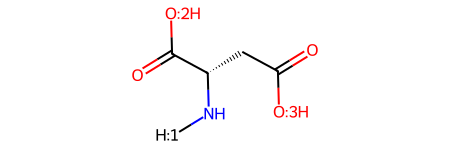

In [30]:
#test
params = Chem.SmilesParserParams()
params.removeHs = False        # <<< 保留显式氢（[H:1]）
# params.strictParsing = True
smi='[H:1]N[C@@H](CC([OH:3])=O)C([OH:2])=O'
m = Chem.MolFromSmiles(smi, params)
m

In [38]:
import copy

In [ ]:
def clear_atomMap(m):
    mol_=copy.deepcopy(m)
    for a in mol_.GetAtoms():
        amap = a.GetAtomMapNum()
        if amap>0:
            a.SetAtomMapNum(0)
    return  mol_            

SyntaxError: 'return' outside function (88919862.py, line 9)

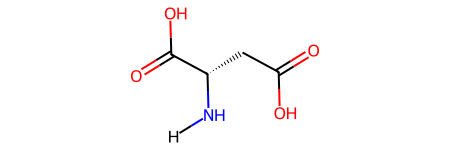

In [49]:
mol_

In [33]:
anchors: Dict[int, int] = {}
leaving: List[int] = []
for a in m.GetAtoms():
    amap = a.GetAtomMapNum()
    # print(amap)
    if amap in [1,2]:#NOTE this version only considering backbone not sidechain
        heavy_nbrs = [nb for nb in a.GetNeighbors() if nb.GetAtomicNum() > 1]
        if len(heavy_nbrs) != 1:
            raise ValueError(
                f"AtomMapNum={amap} 的离去原子需恰有 1 个重原子邻居；"
                f"当前 {len(heavy_nbrs)} 个（atom idx={a.GetIdx()}, sym={a.GetSymbol()})"
            )
        anchors[amap] = heavy_nbrs[0].GetIdx()
        leaving.append(a.GetIdx())
print(anchors,leaving)

{1: 1, 2: 7} [0, 8]


In [216]:
out_='monomersFromHELMCoreLibrary.json'
sdf_='/cadd_data/cw/works/pys/HELMMonomerSets/HELMCoreLibrary/HELMCoreLibrary.sdf'
# monor_df=sdf_to_monomers_json(sdf_, out_)#



In [28]:
xls_='/cadd_data/cw/works/pys/peptseq_smi/data/HELMCoreLibrary.xlsx'
# monor_df.head(2)
HELM_libdf=pd.read_excel(xls_)
# 选择 polymer_type 为 'PEPTIDE' 的行
peptide_df = HELM_libdf[HELM_libdf['polymerType'] == 'PEPTIDE']
print(f'HELMCoreLibrary has number of type AA: {len(peptide_df)}')



HELMCoreLibrary has number of type AA: 322


In [29]:
out = []
for row in peptide_df.itertuples():
    # print(row.polymer_type)  # 使用点号访问属性
    # 添加到 out 列表
    out.append({
        "code": row.symbol,
        "polymer_type": row.polymerType,
        "smiles": row.smiles
    })



In [218]:
codes_sorted=sorted(list(peptide_df.symbol))
intersection2 = set(codes_sorted) & cleaned_vocab_sorted
ptx_only2=cleaned_vocab_sorted - intersection2
len(intersection2),len(ptx_only2)

(54, 178)

In [220]:
nass_3_4={naa for naa in ptx_only2 if len(naa) in [3,4]}
nass_3_4,len(nass_3_4)

({'2Pal',
  'AOC',
  'Acvc',
  'AoC',
  'Aoc',
  'Aph',
  'Cpg',
  'Dfp',
  'Dg1',
  'Dgl',
  'Dql',
  'HCy',
  'HhC',
  'HhF',
  'Hhc',
  'Hph',
  'Hpr',
  'Igl',
  'O2S',
  'O3S',
  'O4S',
  'O5S',
  'O6S',
  'Og1',
  'Ogl',
  'OiC',
  'Oic',
  'Oq1',
  'Oql',
  'PEG4',
  'PEG6',
  'PVA',
  'Sar',
  'Tba',
  'Tet1',
  'Tle',
  'hCha',
  'hhF',
  'nVF3'},
 39)

In [17]:
monomer_json='data/monomersFromHELMCoreLibrary.json'
# with open(monomer_json, 'w', encoding='utf-8') as f:
#     json.dump(out, f, ensure_ascii=False, indent=2)    
lib = MonomerLib(monomer_json)    
# lib.get('Phe')

In [18]:
seqs=['ac-I-H-V-T-I-P-A-D-L-W-D-W-I-N-K-am',
      'ac-Chg-H-V-T-I-P-A-D-L-W-D-W-I-N-am',
    "ac-I-H-1Nal-T-Dip-4Pal-A-D-E-2Nal-D-W-Dip-[Pen]-N-Dab-am",
"ac-Tle-I-H-Tle-T-Hcy-OiC-A-D-Ogl-Phe_4COOH-D-W-Hcy-N-dR-am"]

In [19]:
i_=1
seq=seqs[i_]
# parsed = parse_sequence(seqs[0], lib)
raw_tokens=_tokenize_preserve_brackets(seq)
# res = sequences_to_smiles(seqs, lib)
# parsed
# -------- 1) 识别 N/C 端帽基 --------
# 先只基于 symbol 判断（去括号、统一小写）
head_sym = _strip_brackets(raw_tokens[0]).lower()
tail_sym = _strip_brackets(raw_tokens[-1]).lower()
if head_sym in N_CAPS:
      n_cap = {"symbol": head_sym, "smiles": N_CAPS[head_sym]}
      core_tokens = raw_tokens[1:]    # 去掉 N-cap
else:
      n_cap = DEFAULT_N_CAP
      core_tokens = raw_tokens[:]

if core_tokens:  # 只有在还剩 token 才判断尾帽基
      tail_sym2 = _strip_brackets(core_tokens[-1]).lower()
      if tail_sym2 in C_CAPS:
            c_cap = {"symbol": tail_sym2, "smiles": C_CAPS[tail_sym2]}
            core_tokens = core_tokens[:-1]  # 去掉 C-cap
      else:
            c_cap = DEFAULT_C_CAP
else:
      # 没有残基（只有帽基？极端情况）
      c_cap = DEFAULT_C_CAP
      

In [20]:
# -------- 2) 解析残基（保留你原来的 D 规则） --------
residues: List[Tuple[str, bool]] = []
d_flag_next = False
for t in core_tokens:
    if not t:
        continue
    # 1) 括号 token：作为整体，不再按 '-' 拆分
    if t.startswith('[') and t.endswith(']'):
        inner = t[1:-1].strip()
        want_D = False
        # [D-Arg] / [d-Arg] / [dArg]
        if inner[:2].lower() == 'd-' and len(inner) > 2:
            code_str = inner[2:].strip()
            want_D = True
        elif (inner.lower().startswith('d')
                and lib.resolve_code(inner[1:])
                and not lib.resolve_code(inner)):
            code_str = inner[1:]
            want_D = True
        else:
            code_str = inner

        code = lib.resolve_code(code_str)
        if not code:
            raise KeyError(f"未知 token（括号内）: '{inner}'，请在 monomer 库添加别名/映射")
        residues.append((code, want_D))
        d_flag_next = False
        continue

    # 2) 非括号 token：处理 D 前缀与独立 D
    t_norm = t.strip()
    if t_norm in ('[D', '[d'):
        d_flag_next = True
        # continue

    want_D = False#TODO del as useless
    code_str = t_norm

    code = lib.resolve_code(code_str)
    if not code:
        raise KeyError(f"未知 token: '{t_norm}'，请在 monomer 库添加别名/映射")

    if d_flag_next:
        want_D = True
    residues.append((code, want_D))
    d_flag_next = False
parsed=ParsedSeq(residues=residues, n_cap=n_cap, c_cap=c_cap)    

In [23]:
# 1) 按顺序构造组件列表（先 N-cap，再残基，最后 C-cap）
components = []

# N-cap
if parsed.n_cap and parsed.n_cap.get("symbol") and parsed.n_cap["symbol"].lower() != "h":
    code = lib.resolve_code(parsed.n_cap["symbol"])
    if not code:
        raise KeyError(f"N-cap '{parsed.n_cap['symbol']}' 未在 monomer 库定义（需要 HELM 风格 SMILES）")
    ent = lib.get(code)
    components.append( (ent, False) )  # 帽基无 D/L 概念

# residues
ii=0
for code, is_D in parsed.residues:
    ent = lib.get(code)
    components.append( (ent, is_D) )
    # print(ii,(ent, is_D))
    ii+=1

# C-cap
if parsed.c_cap and parsed.c_cap.get("symbol") and parsed.c_cap["symbol"].lower() != "h":
    code = lib.resolve_code(parsed.c_cap["symbol"])
    if not code:
        raise KeyError(f"C-cap '{parsed.c_cap['symbol']}' 未在 monomer 库定义（需要 HELM 风格 SMILES）")
    ent = lib.get(code)
    components.append( (ent, False) )


if not components:
    raise ValueError("没有可装配的组件（检查序列或库）")

m0, anc0, leave0, t0 = build_fragment(components[0][0], components[0][1])    
# tail_anchors 表示“当前最右端片段”的 anchors；leaving 累加
cur_mol = m0
tail_anchors = anc0
leaving_all: List[int] = list(leave0)   

mols=[]
# 3) 逐个拼接（统一按 R2 — R1）
for ent, want_D in components[1:]:
    mB, ancB, leaveB, tB = build_fragment(ent, want_D)
    print(mB, ancB, leaveB, tB)
    mols.append(mB)
    cur_mol, tail_anchors, leaving_all = fuse_by_anchor_maps_helm(
        cur_mol, tail_anchors, leaving_all,
        mB, ancB, leaveB,
        mapA=2, mapB=1
    )

# 4) 删除所有离去原子并清理
cur_mol = remove_leaving_and_sanitize(cur_mol, leaving_all)

<rdkit.Chem.rdchem.Mol object at 0x7b36697e6810> {1: 1, 2: 9} [0, 10] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e4350> {1: 1, 2: 9} [0, 10] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e70d0> {1: 4, 2: 6} [5, 7] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e44a0> {1: 4, 2: 6} [5, 7] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e6d50> {1: 5, 2: 7} [6, 8] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e7060> {1: 1, 2: 6} [0, 7] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e7220> {1: 2, 2: 4} [3, 5] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e74c0> {1: 1, 3: 4, 2: 7} [0, 5, 8] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e7450> {1: 5, 2: 7} [6, 8] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e73e0> {1: 1, 2: 13} [0, 14] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e7610> {1: 1, 3: 4, 2: 7} [0, 5, 8] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e7760> {1: 1, 2: 13} [0, 14] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x7b36697e7680> {1:

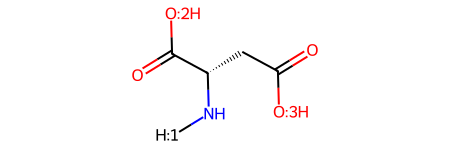

In [26]:
mols[7]

In [185]:
components[4]

({'code': 'T',
  'polymer_type': 'PEPTIDE',
  'smiles': 'C[C@@H](O)[C@H](N[H:1])C([OH:2])=O'},
 False)

In [187]:
m0, anc0, leave0, t0 

(<rdkit.Chem.rdchem.Mol at 0x79c7ee2e93f0>, {2: 1}, [2], 'PEPTIDE')

In [188]:
mB, ancB, leaveB, tB = build_fragment(components[1][0], components[1][1])
# mol = monomer_to_mol_helm(entry, want_D)
# anchors, leaving = anchors_and_leaving_from_helm(mol)

In [189]:
mB, ancB, leaveB, tB

(<rdkit.Chem.rdchem.Mol at 0x79c7eeb555b0>, {1: 5, 2: 7}, [6, 8], 'PEPTIDE')

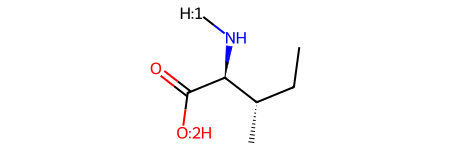

In [190]:
mB

In [191]:
# for a in mB.GetAtoms():
#     amap = a.GetAtomMapNum()
#     print(a.GetSymbol())

In [192]:
# 3) 逐个拼接（统一按 R2 — R1）
for ent, want_D in components[1:]:
    mB, ancB, leaveB, tB = build_fragment(ent, want_D)
    # print(mB, ancB, leaveB, tB)
    cur_mol, tail_anchors, leaving_all = fuse_by_anchor_maps_helm(
        cur_mol, tail_anchors, leaving_all,
        mB, ancB, leaveB,
        mapA=2, mapB=1
    )

# 4) 删除所有离去原子并清理
cur_mol = remove_leaving_and_sanitize(cur_mol, leaving_all)

<rdkit.Chem.rdchem.Mol object at 0x79c7eeb552a0> {1: 5, 2: 7} [6, 8] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7eeb55460> {1: 1, 2: 9} [0, 10] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7eeb55700> {1: 4, 2: 6} [5, 7] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7eeb55460> {1: 4, 2: 6} [5, 7] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7eeb552a0> {1: 5, 2: 7} [6, 8] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7eeb55460> {1: 1, 2: 6} [0, 7] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7eeb55700> {1: 2, 2: 4} [3, 5] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7eeb55460> {1: 1, 3: 4, 2: 7} [0, 5, 8] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7eeb552a0> {1: 5, 2: 7} [6, 8] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7ee2ea880> {1: 1, 2: 13} [0, 14] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7eeb552a0> {1: 1, 3: 4, 2: 7} [0, 5, 8] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7eeb55700> {1: 1, 2: 13} [0, 14] PEPTIDE
<rdkit.Chem.rdchem.Mol object at 0x79c7ee2ea880> {1: 

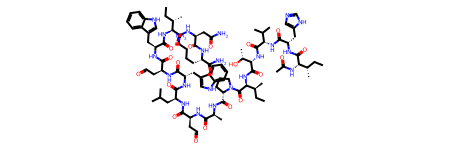

In [193]:
cur_mol

In [194]:
rd_smi=Chem.MolToSmiles(cur_mol)
print(rd_smi)

CC[C@H](C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CC=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CC=O)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@H](C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCCCN)C(N)=O)[C@@H](C)CC)[C@@H](C)CC)[C@@H](C)O)C(C)C


In [195]:
ssm="CC[C@H](C)[C@H](NC(C)=O)C(=O)N[C@@H](CC1=CN=CN1)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CC(O)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC1=CNC2=CC=CC=C12)C(=O)N[C@@H](CC(O)=O)C(=O)N[C@@H](CC1=CNC2=CC=CC=C12)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCCCN)C(N)=O" 
cm=Chem.MolFromSmiles(ssm)
rd_smi2=Chem.MolToSmiles(cm)
print(rd_smi2)

CC[C@H](C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@H](C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCCCN)C(N)=O)[C@@H](C)CC)[C@@H](C)CC)[C@@H](C)O)C(C)C


In [91]:
comps=[]
for code, want_D in parsed[0]:
    ent = lib.get(code)
    print(code, want_D,ent)
    # m = monomer_to_mol(ent, want_D)
    # anchors = _anchor_neighbors(m)#TODO add it in feature 
    # ent = lib.get('D')#TODO should clean as we only need peptdies from the lib
    t = ent.get("polymer_type", "PEPTIDE").upper()
    if t in ("CAP_N", "CAP_C", "CHEM",'PEPTIDE'):
        smi = ent["smiles"]
        m = Chem.MolFromSmiles(smi)
        anchors, leaving = _anchor_neighbors(m)
        # print(smi, '\n  anchors:', anchors, '\n  leaving:', leaving)
    comps.append((m, anchors, ent))    

I False {'code': 'I', 'polymer_type': 'PEPTIDE', 'smiles': 'CC[C@H](C)[C@H](N[H:1])C([OH:2])=O'}
H False {'code': 'H', 'polymer_type': 'PEPTIDE', 'smiles': '[H:1]N[C@@H](Cc1cnc[nH]1)C([OH:2])=O'}
1Nal False {'code': '1Nal', 'polymer_type': 'PEPTIDE', 'smiles': '[H:1]N[C@@H](Cc1cccc2ccccc12)C([OH:2])=O'}
T False {'code': 'T', 'polymer_type': 'PEPTIDE', 'smiles': 'C[C@@H](O)[C@H](N[H:1])C([OH:2])=O'}
Dip False {'code': 'Dip', 'polymer_type': 'PEPTIDE', 'smiles': '[H:1]N[C@@H](C(c1ccccc1)c1ccccc1)C([OH:2])=O'}
4Pal False {'code': '4Pal', 'polymer_type': 'PEPTIDE', 'smiles': '[H:1]N[C@@H](Cc1ccncc1)C([OH:2])=O'}
A False {'code': 'A', 'polymer_type': 'PEPTIDE', 'smiles': 'C[C@H](N[H:1])C([OH:2])=O'}
E True {'code': 'E', 'polymer_type': 'PEPTIDE', 'smiles': '[H:1]N[C@@H](CCC([OH:3])=O)C([OH:2])=O'}
2Nal False {'code': '2Nal', 'polymer_type': 'PEPTIDE', 'smiles': '[H:1]N[C@@H](Cc1ccc2ccccc2c1)C([OH:2])=O'}
W True {'code': 'W', 'polymer_type': 'PEPTIDE', 'smiles': '[H:1]N[C@@H](Cc1c[nH]c2ccccc

In [92]:
cur_mol, cur_anc, cur_ent = comps[0]
for m, anc, ent in comps[1:]:
    # 判定该连接是主链还是端基
    # 规则：
    #   - 若前者有 R2 且后者有 R1：先尝试主链连接
    #   - 若后者是 CAP_C：用前者 R2 与它 R1
    #   - 若后者是 CAP_N：用它 R2 与前者 R1（此时需要把 CAP 放到“前面”）
    tB = ent.get("type","PEPTIDE").upper()
    if (2 in cur_anc) and (1 in anc):
        cur_mol = fuse_by_anchors(cur_mol, m, cur_anc[2], anc[1])
        # 合并后需要更新“当前分子”的锚点索引（简单起见：重新计算）
        cur_mol = Chem.Mol(cur_mol)
        cur_anc = _anchor_neighbors(cur_mol)
    elif tB=="CAP_C" and (2 in cur_anc) and (1 in anc):
        cur_mol = fuse_by_anchors(cur_mol, m, cur_anc[2], anc[1])
        cur_mol = Chem.Mol(cur_mol); cur_anc = _anchor_neighbors(cur_mol)
    elif tB=="CAP_N" and (1 in cur_anc) and (2 in anc):
        # CAP_N 应该接在“最前面”，所以把次序调换连
        cur_mol = fuse_by_anchors(m, cur_mol, anc[2], cur_anc[1])
        cur_mol = Chem.Mol(cur_mol); cur_anc = _anchor_neighbors(cur_mol)
    else:
        raise RuntimeError(f"无法决定如何连接：...-{comps[0][2].get('code')} - {ent.get('code')}，请检查锚点")


RuntimeError: 无法决定如何连接：...-I - H，请检查锚点

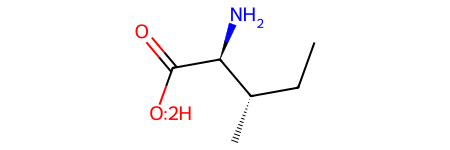

In [83]:
cur_mol

In [76]:
ent = lib.get('D')#TODO should clean as we only need peptdies from the lib
print(ent.get('code'))
t = ent.get("polymer_type", "PEPTIDE").upper()
if t in ("CAP_N", "CAP_C", "CHEM",'PEPTIDE'):
    smi = ent["smiles"]
    print(smi)
    m = Chem.MolFromSmiles(smi)
    m = Chem.MolFromSmiles(smi)
    anchors, leaving = _anchor_neighbors(m)
    print(smi, '\n  anchors:', anchors, '\n  leaving:', leaving)
comps.append((m, anchors, ent))    

D
[H:1]N[C@@H](CC([OH:3])=O)C([OH:2])=O
[H:1]N[C@@H](CC([OH:3])=O)C([OH:2])=O 
  anchors: {3: 3, 2: 6} 
  leaving: [4, 7]


In [20]:
ptx_only2, "2Nal" in codes_sorted, "1Nal" in codes_sorted

({'1PEG21PEG2ISOGluC12',
  '1PEG21PEG2IsoGluPalm',
  '1PEG2_1PEG2_ISoGlu_C12',
  '2Pal',
  '3Hydroxypropionicacid',
  '4RBenzyloxyPro',
  '4RPhePro',
  '4SCF3Pro',
  '4SCyclohexPro',
  'AOC',
  'Acvc',
  'AdamantylGly',
  'AlaCF3',
  'AlaCHF2',
  'Ala_CyCBu',
  'Ala_CycBu',
  'AoC',
  'Aoc',
  'Aph',
  'AzetidinOne',
  'Azetidinone',
  'C6_Diacid',
  'Cpg',
  'CyclopropanecarboxylicAcid',
  'Cyclopropyl_Ala',
  'Dab2HyAC',
  'DabMs',
  'DabTs',
  'Dab_AC',
  'Dab_ACetyl',
  'Dab_Acetyl',
  'Dfp',
  'Dg1',
  'Dgl',
  'Dql',
  'EtOMe',
  'Glu_OMe',
  'GlutariC_ACid',
  'GlutariC_Acid',
  'Glutaric_Acid',
  'GlycolicAcid',
  'HCy',
  'H_Cha',
  'Hcy(1:R3)',
  'Hcy(2:R3)',
  'HhC',
  'HhF',
  'Hhc',
  'Hhc(1:R3)',
  'Hph',
  'Hpr',
  'ISOValeriC ACid',
  'ISOValeriC_ACid',
  'ISOValeriC_Acid',
  'ISOvaleriC_ACid',
  'ISOvaleric Acid',
  'ISOvaleric_Acid',
  'Igl',
  'IsOValeriC_ACid',
  'IsOValeriC_Acid',
  'IsOvaleriC_Acid',
  'IsOvaleriC_acid',
  'IsOvaleric Acid',
  'IsOvaleric_Acid',
 

In [159]:
print(f'need process:\n {cleaned_only}'),type(cleaned_only)

need process:
 {'Cit', 'LyS_PEG12_NH', 'cyclopropyl_Ala', 'aMe_Trp', 'hCha', 'LyS_Dimethyl', 'Cha', 'LyS_Dimethy1', 'Orn_AC', 'd3Pal', 'Dab_ACetyl', 'nVF3', 'Ala_CyCBu', 'dV', 'Glu_OMe', 'LyS_1PEG2_1PEG2_IsoGlu_C12', 'Abu', '4RBenzyloxyPro', 'Hpr', 'Methanesulfonyl_Acetic_Acid', 'LyS_PEG4_PEG4_NH2', 'dDab2HyAC', 'CyclopropanecarboxylicAcid', 'IsovaleriC_acid', 'dA', 'dD', '4SCyclohexPro', 'LyS_1PEG2_1PEG2_ISoGlu_C12', 'dL', 'Aib', 'IsoValeriC_Acid', 'O3S_Reduced', 'Trp_6CONH2', 'dS', 'Gla', 'Oq1', 'Hph', 'bA', 'h_Cha', 'Isovaleric_Acid', 'Phe_4CF3', 'Isovaleric_acid', 'Phe_4_2ae', 'Sar', 'ISOValeriC_Acid', 'aMe_Phe', 'Acvc', 'HhF', 'LySMs', 'Lys_Ac', 'K(5:R3)', 'dK', 'O5S', 'IsOValeriC_Acid', 'NMe_His', 'Hcy', 'Trp_6C1', 'dE', 'dI', 'Aoc', 'dC', 'hR', 'AlaCHF2', 'Hhc', '1Nal', 'Phe_4Ad', 'O4S', 'IsOvaleric_Acid', 'Trp_5Et', 'Lys_Dimethyl', 'Lys2HyAc', 'd2Pal', 'Phe_4Me', 'LyS AC', 'Cpg', 'GlutariC_ACid', 'Oql', 'Trp_6Cl', 'Trp_4Me', 'O3S_Me_Reduced', 'dQ', 'O6S', 'Phe_4guan', 'Dab_AC',

(None, set)

In [ ]:
# vocab = dict(VOCAB_SEED_DEFAULT)

In [80]:
pat = re.compile(r"am[\s\S]*[\(（][\s\S]*SEQ", re.IGNORECASE)
SEQ_REF_RE = re.compile(r"[\(（]\s*SEQ[\s\S]*?ID[\s\S]*?NO\s*[:：]\s*(?:\d\s*+)\s*[\)）]", re.IGNORECASE)
# Filter out tokens containing "am (SEQ" or "am(SEQ" (case-insensitive, allow full-width '(')
# pat = re.compile(r"am\s*[\(（]\s*seq", re.IGNORECASE)
kept = []
removed = []
for t in vocab_sorted:
    if pat.search(t) or SEQ_REF_RE.search(t):
        removed.append(t)
    else:
        kept.append(t)

In [1]:
from rdkit import Chem
from rdkit.Chem import rdmolfiles

seq = "ACDEFGHIKLMNPQRSTVWY"  # 仅标准AA
mol = rdmolfiles.MolFromFASTA(seq)  # FASTA -> Mol（标准氨基酸/核酸）
helm = rdmolfiles.MolToHELM(mol)    # 需要分子里有 AtomMonomerInfo（MolFromFASTA 会设置）
fasta_back = rdmolfiles.MolToFASTA(mol)
print(helm)
print(fasta_back)


PEPTIDE1{A.C.D.E.F.G.H.I.K.L.M.N.P.Q.R.S.T.V.W.Y}$$$$
>
ACDEFGHIKLMNPQRSTVWY



In [4]:
mol_l = rdmolfiles.MolFromFASTA(seq)  # FASTA -> Mol（标准氨基酸/核酸）

mol_d = rdmolfiles.MolFromFASTA(seq,flavor=1)  # FASTA -> Mol（标准氨基酸/核酸）


In [2]:
mol_l

NameError: name 'mol_l' is not defined

In [5]:
import smi2seq
# from smi2seq import FragmentMatcher
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, rdmolops





def get_backbone_atoms(mol: Chem.Mol):
    """Get peptide backbone atoms (N-CA-C(=O))"""
    pattern = Chem.MolFromSmarts("[N;$(NC)]-[C;$(C(N)C=O)]-[C;$(C=O)]")
    return mol.GetSubstructMatches(pattern)

In [37]:
lib_path='data/monomersFromHELMCoreLibrary.json'
AAmatcher = FragmentMatcher(lib_path)

In [6]:
# smiles=
# ac-I-H-V-T-I-P-A-D-L-W-D-W-I-N-K-am(SEQ ID NO:1)
clean="CC[C@H](C)[C@H](NC(C)=O)C(=O)N[C@@H](CC1=CN=CN1)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CC(O)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC1=CNC2=CC=CC=C12)C(=O)N[C@@H](CC(O)=O)C(=O)N[C@@H](CC1=CNC2=CC=CC=C12)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCCCN)C(N)=O"

mol = Chem.MolFromSmiles(clean)
AllChem.Compute2DCoords(mol)
Chem.AssignStereochemistryFrom3D(mol)

pattern = Chem.MolFromSmarts("[C;$(C=O)]-[N;$(NC)]-[C;$(C(N)C=O)]")
matches = mol.GetSubstructMatches(pattern)

# fragments=matcher.break_into_fragments(mol)

In [7]:
N_CA_Cs=get_backbone_atoms(mol)#N-CA-C(=O)
backbone_ids = [x for row in N_CA_Cs for x in row]
print(backbone_ids)

[5, 4, 9, 11, 12, 19, 21, 22, 26, 28, 29, 33, 35, 36, 41, 43, 47, 48, 50, 51, 53, 55, 56, 61, 63, 64, 69, 71, 72, 83, 85, 86, 91, 93, 94, 105, 107, 108, 113, 115, 116, 121, 123, 124, 130]


In [156]:
# N_CA_Cs=get_backbone_atoms(mol)#N-CA-C(=O)
peptide_bondsidx=[]
for i, ncac in enumerate(N_CA_Cs):
    if i ==len(N_CA_Cs)-1: break
    n,ca,c=ncac
    # print(c,N_CA_Cs[i+1][0])
    bondidx=mol.GetBondBetweenAtoms(c,N_CA_Cs[i+1][0]).GetIdx()
    peptide_bondsidx.append(bondidx)

In [158]:
fragmol = rdmolops.FragmentOnBonds(mol, peptide_bondsidx, addDummies=True)
frags = Chem.GetMolFrags(fragmol, asMols=True, sanitizeFrags=True)

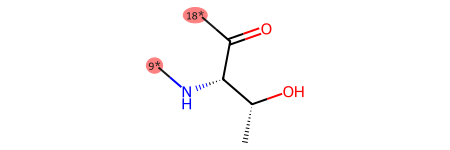

In [118]:
frags[1]

In [110]:
Ncap,Ccap=[],[]
for i, frag in enumerate(frags):
    # n_dummy = sum(1 for a in frag.GetAtoms() if a.GetAtomicNum() == 0)
    n_dummy_smarts = len(frag.GetSubstructMatches(Chem.MolFromSmarts("[#0]")))
    # print(i,n_dummy_smarts)
    if n_dummy_smarts==1:
        N=N_CA_Cs[i][0]
        C=N_CA_Cs[i][2]
        Nnei=[(a.GetIdx(),N)  for a in mol.GetAtomWithIdx(N).GetNeighbors() if a.GetIdx() not in  backbone_ids ]
        if len(Nnei)>0:#TODO add index to cut bond 
            Ncap.append((Nnei,i))
            continue
        else:
            Cnei=[(a.GetIdx(),C) for a in mol.GetAtomWithIdx(C).GetNeighbors() if a.GetIdx() not in  backbone_ids
                   and mol.GetBondBetweenAtoms(C,a.GetIdx()).GetBondType() != rdkit.Chem.rdchem.BondType.DOUBLE]
            Ccap.append((Cnei,i))
        # Cnei=mol.GetAtomWithIdx(C).GetNeighbors()
        print(N,C)

print(" Nnei,Cnei",( Ncap,Ccap))

121 130
 Nnei,Cnei ([([(6, 5)], 0)], [([(131, 130)], 14)])


In [174]:
Chem.MolToSmiles(frags[0])

'[11*]C(=O)[C@@H](NC(C)=O)[C@@H](C)CC'

In [111]:
Nterbond=mol.GetBondBetweenAtoms(*Ncap[0][0][0]).GetIdx()
Cterbond=mol.GetBondBetweenAtoms(*Ccap[0][0][0]).GetIdx()

In [112]:
Ncap_fragmol = rdmolops.FragmentOnBonds(mol, [Nterbond], addDummies=True)
Ncap_frags = Chem.GetMolFrags(Ncap_fragmol, asMols=True, sanitizeFrags=True)
Ncap_frags = sorted(Ncap_frags, key=lambda mol: mol.GetNumHeavyAtoms())
Ccap_fragmol = rdmolops.FragmentOnBonds(mol, [Cterbond], addDummies=True)
Ccap_frags = Chem.GetMolFrags(Ccap_fragmol, asMols=True, sanitizeFrags=True)
Ccap_frags = sorted(Ccap_frags, key=lambda mol: mol.GetNumHeavyAtoms())



In [113]:
n_cap_smiles=Chem.MolToSmiles(Ncap_frags[0], isomericSmiles=True) if Ncap !=[] else 'H'
c_cap_smiles=Chem.MolToSmiles(Ccap_frags[0], isomericSmiles=True) if Ccap !=[] else 'H'
print(n_cap_smiles,c_cap_smiles)

[5*]C(C)=O [130*]N


In [114]:
# Common caps and modifications
N_CAPS = {
    "ac": "CC(=O)*",      # Acetyl
    "formyl": "C(=O)*",   # Formyl
}

C_CAPS = {
    "am": "N*",       # Amide (-CONH2)
    "ome": "COC(=O)*",     # Methyl ester
}

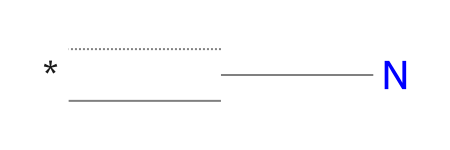

In [115]:
Chem.MolFromSmarts(C_CAPS['am'])

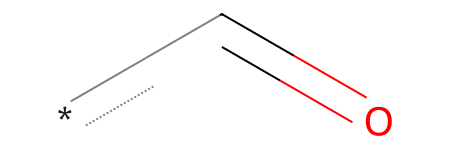

In [77]:
ncap_m=Chem.MolFromSmarts(N_CAPS['formyl'])
ncap_m

In [42]:
# Match terminal caps to known patterns
n_cap = "H"
c_cap = "H"
if n_cap_smiles != "H":
    n_mol = Chem.MolFromSmiles(n_cap_smiles)
    for cap_name, smarts in N_CAPS.items():
        pattern = Chem.MolFromSmarts(smarts)
        if pattern and n_mol.HasSubstructMatch(pattern):
            n_cap = cap_name
            break
    if n_cap == "H":
        n_cap = f"[N-cap:{n_cap_smiles}]"

if c_cap_smiles != "H":
    c_mol = Chem.MolFromSmiles(c_cap_smiles)
    for cap_name, smarts in C_CAPS.items():
        pattern = Chem.MolFromSmarts(smarts)
        if pattern and c_mol.HasSubstructMatch(pattern):
            c_cap = cap_name
            break
    if c_cap == "H":
        c_cap = f"[C-cap:{c_cap_smiles}]"
# Build sequence
sequence_parts = []
if n_cap != "H":
    sequence_parts.append(n_cap)

In [82]:
sequence_parts

['[N-cap:CC=O]']

In [83]:
from rdkit.Chem import rdFMCS


In [84]:
AAmatcher.templates

{'A': {'mol': <rdkit.Chem.rdchem.Mol at 0x7b8d40eb2420>,
  'smiles': 'C[C@H](N)C(=O)O',
  'backbone': (2, 1, 3),
  'sidechain': 'CC.O.O',
  'type': 'PEPTIDE'},
 'C': {'mol': <rdkit.Chem.rdchem.Mol at 0x7b8d40eb2340>,
  'smiles': 'N[C@@H](CS)C(=O)O',
  'backbone': (0, 1, 4),
  'sidechain': 'CCS.O.O',
  'type': 'PEPTIDE'},
 'D': {'mol': <rdkit.Chem.rdchem.Mol at 0x7b8d40eb23b0>,
  'smiles': 'N[C@@H](CC(=O)O)C(=O)O',
  'backbone': (0, 1, 6),
  'sidechain': 'CCC(=O)O.O.O',
  'type': 'PEPTIDE'},
 'E': {'mol': <rdkit.Chem.rdchem.Mol at 0x7b8d40eb2570>,
  'smiles': 'N[C@@H](CCC(=O)O)C(=O)O',
  'backbone': (0, 1, 7),
  'sidechain': 'CCCC(=O)O.O.O',
  'type': 'PEPTIDE'},
 'F': {'mol': <rdkit.Chem.rdchem.Mol at 0x7b8d40eb25e0>,
  'smiles': 'N[C@@H](Cc1ccccc1)C(=O)O',
  'backbone': (0, 1, 9),
  'sidechain': 'CCc1ccccc1.O.O',
  'type': 'PEPTIDE'},
 'G': {'mol': <rdkit.Chem.rdchem.Mol at 0x7b8d40eb2490>,
  'smiles': 'NCC(=O)O',
  'backbone': (0, 1, 2),
  'sidechain': 'C.O.O',
  'type': 'PEPTIDE'},


In [87]:
# for i, frag in enumerate(frags):
i=0
frag=frags[0]
temp=AAmatcher.templates
matched=[]
mcs_nums=[]
for code, tmplate in AAmatcher.templates.items():
    mol2_h=tmplate['mol']
    mcs = rdFMCS.FindMCS([frag, mol2_h],
    timeout=1,
    matchValences=True,
    ringMatchesRingOnly=True,
    atomCompare=rdFMCS.AtomCompare.CompareElements,
    bondCompare=rdFMCS.BondCompare.CompareOrder,
    completeRingsOnly=True)
    mcs_nums.append([code, mcs.numAtoms])
mcs_nums=sorted(mcs_nums,key=lambda c_n : c_n[1],reverse=True)    

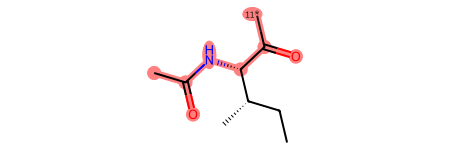

In [97]:
frag

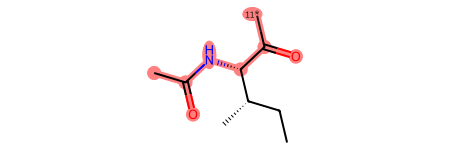

In [94]:
frag

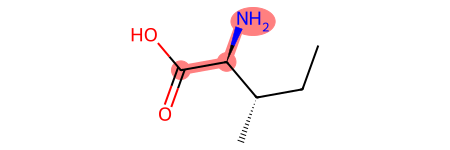

In [93]:
AAmatcher.templates['I']['mol']

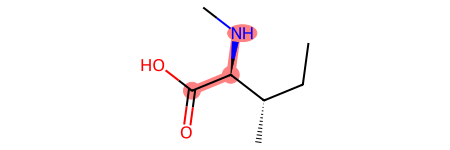

In [92]:
AAmatcher.templates['meI']['mol']

In [95]:
def get_chirality_from_chiral_tag(smiles_or_mol):
    """直接从手性标签判断 L/D"""
    if isinstance(smiles_or_mol, str):
        mol = Chem.MolFromSmiles(smiles_or_mol)
    else:
        mol = smiles_or_mol
    if mol is None:
        return None
    # 查找 alpha 碳
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'C':
            neighbors = [n.GetSymbol() for n in atom.GetNeighbors()]
            if 'N' in neighbors and 'O' in neighbors:
                chiral_tag = atom.GetChiralTag()
                if chiral_tag == Chem.ChiralType.CHI_TETRAHEDRAL_CCW:
                    return 'L'  # 逆时针通常是 L 型
                elif chiral_tag == Chem.ChiralType.CHI_TETRAHEDRAL_CW:
                    return 'D'  # 顺时针通常是 D 型
    return None

In [116]:
# get_chirality_from_chiral_tag(frag)
for atom in frag.GetAtoms():
    if atom.GetSymbol() == 'C':
        neighbors = [n.GetSymbol() for n in atom.GetNeighbors()]
        if 'N' in neighbors and 'O' in neighbors:
            chiral_tag = atom.GetChiralTag()
            print(chiral_tag)


CHI_UNSPECIFIED


In [99]:
neighbors

['C', 'O', '*']

In [54]:
from rdkit.Chem import rdFMCS


In [78]:

mol2_h = Chem.AddHs(ncap_m)
for i, frag in enumerate(frags):
    mol1_h = Chem.AddHs(frag)
    mcs = rdFMCS.FindMCS([mol1_h, mol2_h],
        timeout=1,
        matchValences=True,
        ringMatchesRingOnly=True,
        atomCompare=rdFMCS.AtomCompare.CompareElements,
        bondCompare=rdFMCS.BondCompare.CompareOrder,
        completeRingsOnly=True)
    if mcs.numAtoms > 0:
        print(i,mcs.numAtoms)

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1


In [81]:
frags[0].GetSubstructMatches(ncap_m)

((6, 8, 5), (6, 8, 7), (9, 10, 4), (9, 10, 11))

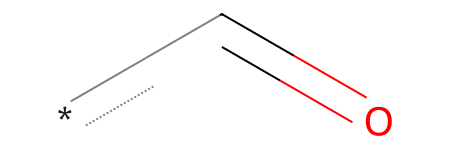

In [80]:
mol2_h

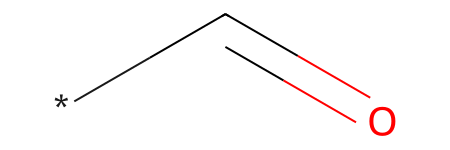

In [61]:
ncap_m

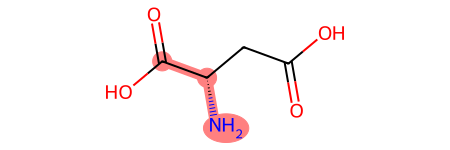

In [73]:
AAmatcher.templates['D']['mol']

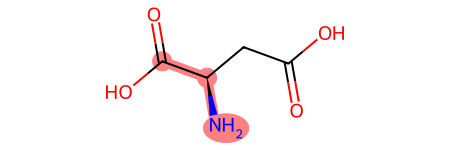

In [75]:
AAmatcher.templates['dD']['mol']

In [39]:
AAmatcher.templates['ac']

{'mol': <rdkit.Chem.rdchem.Mol at 0x7b8d40eb3530>,
 'smiles': 'CC(=O)O',
 'backbone': None,
 'sidechain': '',
 'type': 'PEPTIDE'}

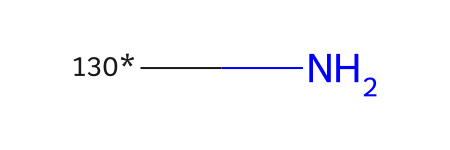

In [ ]:
# Process fragments
for frag, pos, backbone in fragments:#frags.append((frag, pos, backbone))
    code, is_d = self.matcher.match_fragment(frag, pos, backbone)
    if is_d:
        if code.startswith("X-"):
            sequence_parts.append(f"[D@{code}]")
        else:
            sequence_parts.append(f"[D-{code}]")
    else:
        if code.startswith("X-"):
            sequence_parts.append(f"[{code}]")
        else:
            sequence_parts.append(code)

if c_cap != "H":
    sequence_parts.append(c_cap)

return "-".join(sequence_parts)

In [19]:
#cut Ncap Ccap
fragmol = rdmolops.FragmentOnBonds(mol, peptide_bondsidx, addDummies=True)
frags = Chem.GetMolFrags(fragmol, asMols=True, sanitizeFrags=True)

In [20]:
fragN=Ncap[0][1] if Ncap !=[] else 0
fragC=Ccap[0][1] if Ccap !=[] else len(frags) -1
print(fragN,fragC)
n_atom = mol.GetAtomWithIdx(Ncap[0][0][0][0])#Nterm
non_h_neighbors = []
for neighbor in n_atom.GetNeighbors():
    if neighbor.GetSymbol() != "H" and neighbor.GetIdx() not in backbone_ids:
        non_h_neighbors.append(neighbor.GetIdx())

0 14


In [22]:
Ccap[0][0][0][0]

131

In [23]:
C_atom = mol.GetAtomWithIdx(Ccap[0][0][0][0])#Cterm
c_non_h_neighbors = []
for neighbor in C_atom.GetNeighbors():
    if neighbor.GetSymbol() != "H" and neighbor.GetIdx() not in backbone_ids:
        c_non_h_neighbors.append(neighbor.GetIdx())

In [82]:
non_h_neighbors,c_non_h_neighbors

([7, 8], [])

In [ ]:
#todo MATCH TEMPLATE FOR aa cap
# Create editable mol to remove caps
em = Chem.EditableMol(frags[fragN])

({6: 5}, 0)

In [62]:
mol.GetBondBetweenAtoms(C,132).GetBondType()

rdkit.Chem.rdchem.BondType.DOUBLE

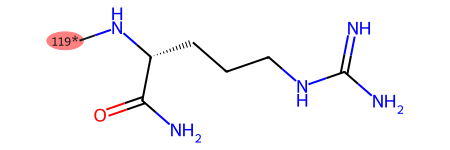

In [50]:
frags[-1]


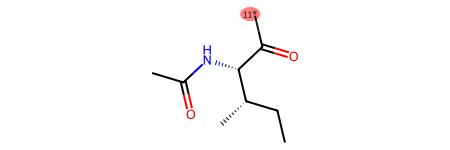

In [51]:
frags[0]


In [53]:
N_CA_Cs

((5, 4, 9),
 (11, 12, 16),
 (18, 19, 23),
 (25, 26, 30),
 (32, 33, 38),
 (40, 44, 45),
 (47, 48, 50),
 (52, 53, 58),
 (60, 61, 66),
 (68, 69, 80),
 (82, 83, 88),
 (90, 91, 102),
 (104, 105, 110),
 (112, 113, 119),
 (121, 122, 130))

In [8]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_molecular_weight(smiles):
    """计算 SMILES 的分子量"""
    if pd.isna(smiles) or smiles == '':
        return 0.0
    try:
        mol = Chem.MolFromSmiles(str(smiles))
        if mol is None:
            return 0.0
        return Descriptors.MolWt(mol)
    except:
        return 0.0

# 读取 Excel 文件
input_file = "data/WO2025137159_IL17_PTX2025_20251028.xlsx"  # 替换为你的文件路径
df = pd.read_excel(input_file)

# 计算分子量
print("正在计算分子量...")
df['Molecular_Weight'] = df['SMILES'].apply(calculate_molecular_weight)

mwcutoff=3000
# 分割数据
dimer_df = df[df['Molecular_Weight'] > mwcutoff]
monomer_df = df[df['Molecular_Weight'] <= mwcutoff]

# 保存结果
dimer_df.to_csv('data/Dimer.csv', index=False)
monomer_df.to_csv('data/Monomer.csv', index=False)

print(f"处理完成!")
print(f"总行数: {len(df)}")
print(f"Dimer (分子量 > {mwcutoff}): {len(dimer_df)} 行")
print(f"Monomer (分子量 ≤ {mwcutoff}): {len(monomer_df)} 行")

正在计算分子量...
处理完成!
总行数: 897
Dimer (分子量 > 3000): 485 行
Monomer (分子量 ≤ 3000): 412 行


In [1]:
import smi2seq
from smi2seq import SMILES2Sequence
from utils import *

In [2]:
# ac-I-H-V-T-I-P-C-D-L-W-C-W-I-N-dR-am,
smiles="CC[C@H](C)[C@H](NC(C)=O)C(=O)N[C@@H](CC1=CN=CN1)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N1CCC[C@H]1C(=O)N[C@H]1CSCC2=CC=C(CSC[C@H](NC(=O)[C@H](CC3=CNC4=CC=CC=C34)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(O)=O)NC1=O)C(=O)N[C@@H](CC1=CNC3=CC=CC=C13)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H](CCCNC(N)=N)C(N)=O)C=C2"
# ac-K-dR-LyS_1PEG2_1PEG2_IsoGlu_C12-am,
smiles='[H]CC(N[C@H](C(N[C@@H](C(N[C@H](C(N)=O)CCCCNC(COCCOCCNC(COCCOCCNC(CC[C@@H](C(O)=O)NC(CCCCCCCCCCC)=O)=O)=O)=O)=O)CCCNC(N)=N)=O)CCCCN[H])=O'

# ac-I-T-V-T-I-P-A-D-L-W-D-W-I-K-dR-LyS_1PEG2_1PEG2_IsoGlu_C12-am,[
smiles="[H]CC(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N1CC([H])C[C@H]1C(=O)C[C@H](NN[C@@H](CC(O)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC1=CNC2=CC=CC=C12)C(=O)N[C@@H](CC(O)=O)C(=O)N[C@@H](CC1=CNC2=CC=CC=C12)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCCCN[H])C(=O)N[C@H](CCCNC(N)=N)C(=O)N[C@@H](CCCCNC(=O)COCCOCCNC(=O)COCCOCCNC(=O)CC[C@H](NC(=O)CCCCCCCCCCC)C(O)=O)C(N)=O)C([H])=O"


In [3]:
# ac-Chg-H-V-T-I-P-A-D-L-W-D-W-I-N-am,
smiles="CC[C@H](C)[C@H](NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC1=CN=CN1)NC(=O)[C@@H](NC(C)=O)C1CCCCC1)C(C)C)[C@@H](C)O)[C@@H](C)CC)C(=O)N[C@@H](CC(N)=O)C(N)=O"


In [4]:
lib='data/monomersFromHELMCoreLibrary.json'
# converter = smi2seq.SMILES2Sequence(lib_path="data/monomersFromHELMCoreLibrary.json")
converter = SMILES2Sequence(lib_path=lib)

In [5]:
converter.templates

{'A': TemplateEntry(code='A', mol=<rdkit.Chem.rdchem.Mol object at 0x76469ca5e9d0>, canonical='C[C@H](N)C(=O)O', fingerprint=<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x76469ca5eab0>, polymer_type='PEPTIDE', side_canonical='CCN', side_fp=<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x76469ca5ec00>, components=None, aliases=None),
 'C': TemplateEntry(code='C', mol=<rdkit.Chem.rdchem.Mol object at 0x76469ca5ea40>, canonical='N[C@@H](CS)C(=O)O', fingerprint=<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x76469ca5eb90>, polymer_type='PEPTIDE', side_canonical='NCCS', side_fp=<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x76469ca5eb20>, components=None, aliases=None),
 'D': TemplateEntry(code='D', mol=<rdkit.Chem.rdchem.Mol object at 0x76469ca5e8f0>, canonical='N[C@@H](CC(=O)O)C(=O)O', fingerprint=<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x76469ca5ef80>, polymer_type='PEPTIDE', side_canonical='NCCC(=O)O', side_fp=<rdkit.D

In [28]:
cust_smi='O=C(OCCOCCO)N[C@H](C(O)=O)CCCCNC'
mol = Chem.MolFromSmiles(cust_smi)
matches = list(get_backbone_atoms(mol))
n_idx, ca_idx, c_idx = matches[0]
print(n_idx, ca_idx, c_idx)

9 10 11


In [34]:
rw = Chem.RWMol(mol)

n_atom = rw.GetAtomWithIdx(n_idx)

h_idx = None
for nb in n_atom.GetNeighbors():
    if nb.GetAtomicNum() == 1:
        h_idx = nb.GetIdx()
        break
print(h_idx,"h_idx")
if h_idx is None:
    h_atom = Chem.Atom(1)
    h_atom.SetNoImplicit(True)
    h_atom.SetFormalCharge(0)
    h_atom.SetAtomMapNum(1)
    h_idx = rw.AddAtom(h_atom)
    rw.AddBond(n_idx, h_idx, Chem.BondType.SINGLE)
else:
    print('never happen')
    h_atom = rw.GetAtomWithIdx(h_idx)
    h_atom.SetAtomMapNum(1)
    h_atom.SetNoImplicit(True)
    h_atom.SetFormalCharge(0)

None h_idx


In [35]:
# ensure carbonyl carbon has a hydroxyl [OH:2]
carbon = rw.GetAtomWithIdx(c_idx)
o_idx = None
for bond in carbon.GetBonds():
    other = bond.GetOtherAtom(carbon)
    if bond.GetBondType() == Chem.BondType.SINGLE and other.GetAtomicNum() == 8:
        o_idx = other.GetIdx()
        break
if o_idx is None:
    o_atom = Chem.Atom(8)
    o_atom.SetFormalCharge(0)
    o_idx = rw.AddAtom(o_atom)
    rw.AddBond(c_idx, o_idx, Chem.BondType.SINGLE)
o_atom = rw.GetAtomWithIdx(o_idx)
o_atom.SetFormalCharge(0)
o_atom.SetAtomMapNum(2)
o_atom.SetNoImplicit(True)
o_atom.SetNumExplicitHs(1)

helm_mol = rw.GetMol()
Chem.SanitizeMol(helm_mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

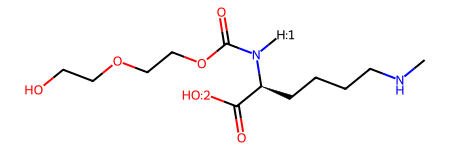

In [36]:
helm_mol

In [41]:
helm_smiles=Chem.MolToSmiles(helm_mol, isomericSmiles=True, canonical=False)
helm_smiles

'O=C(OCCOCCO)N([C@H](C([OH:2])=O)CCCCNC)[H:1]'

In [ ]:
molecule = Chem.MolFromSmiles(helm_smiles,sanitize=False)
molecule

ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolFromSmiles(str)
did not match C++ signature:
    MolFromSmiles(boost::python::api::object SMILES, bool sanitize=True, boost::python::dict replacements={})
    MolFromSmiles(boost::python::api::object SMILES, RDKit::v1::SmilesParserParams params)

In [9]:
mol, ca_idx, backbone_atoms=P_T,3,(7,3,1)
side_atoms = converter._collect_sidechain_atoms(
                mol, ca_idx, backbone_atoms
            )
print("side_atoms",side_atoms)
smiles = Chem.MolFragmentToSmiles(#TODO check if Pro AA sidechain cycle with backbone
                mol, atomsToUse=sorted(side_atoms), isomericSmiles=True
            )
print(smiles)

side_atoms {3, 4, 5, 6, 7}
C1CCNC1


In [10]:
frag = Chem.MolFromSmiles(smiles)
Chem.SanitizeMol(frag)
canonical = Chem.MolToSmiles(frag, isomericSmiles=True)

In [11]:
canonical

'C1CCNC1'

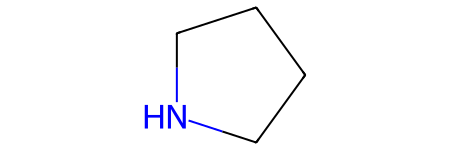

In [12]:
frag

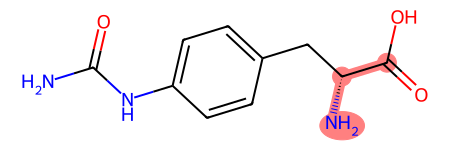

In [7]:
converter.templates['D-Phe_4ureido'].mol

In [14]:
def mol_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol


In [15]:
mol = Chem.MolFromSmiles(smiles)
pattern = Chem.MolFromSmarts("[N;$(NCC(=O))]-[C;$(C(N)C=O)]-[C;$(C(=O)CN)]")
matches: List[Tuple[int, int, int]] = list(mol.GetSubstructMatches(pattern))
print(len(matches),matches)

0 []


In [16]:
sorted_matches = [
        match for _, match in sorted(
            enumerate(matches), key=lambda item: min(item[1])
        )
    ]

sorted_matches,len(sorted_matches)

([], 0)

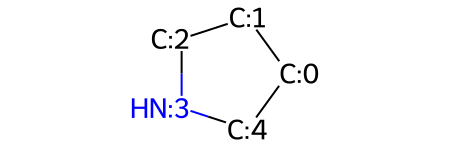

In [17]:
mol_atom_index(mol)

In [18]:
convert.template

NameError: name 'convert' is not defined

In [19]:
matches = list(get_backbone_atoms(mol))
print(len(matches),matches)

0 []


In [20]:
# clean = clean_smiles(smiles)
mol = Chem.MolFromSmiles(smiles)
matches = list(get_backbone_atoms(mol))
residues = [{"N": n, "CA": ca, "C": c} for (n, ca, c) in matches]
matches,len(matches)

([], 0)

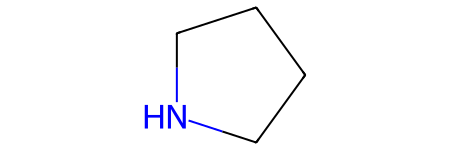

In [21]:
mol

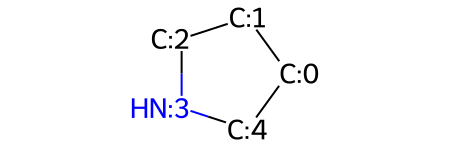

In [22]:
mol_atom_index(mol)

In [23]:
# if not residues:
    # return [], {"n_cap": set(), "c_cap": set()}

# Identify caps first by checking substituents on terminal N and C
n_cap_atoms = set()
c_cap_atoms = set()

# Check N-terminal nitrogen
n_atom = mol.GetAtomWithIdx(residues[0]["N"])
for nb in n_atom.GetNeighbors():
    if (nb.GetIdx() != residues[0]["CA"] and 
        nb.GetAtomicNum() != 1):  # Not H and not CA
        n_cap_atoms.add(nb.GetIdx())
        # Add connected non-backbone atoms recursively
        stack = [nb.GetIdx()]
        while stack:
            idx = stack.pop()
            atom = mol.GetAtomWithIdx(idx)
            for next_nb in atom.GetNeighbors():
                next_idx = next_nb.GetIdx()
                if (next_idx not in n_cap_atoms and 
                    next_idx not in [residues[0]["N"], residues[0]["CA"], residues[0]["C"]]):
                    n_cap_atoms.add(next_idx)
                    stack.append(next_idx)

# Check C-terminal carbonyl
c_atom = mol.GetAtomWithIdx(residues[-1]["C"])
for nb in c_atom.GetNeighbors():
    if (nb.GetIdx() != residues[-1]["CA"] and 
        not (nb.GetAtomicNum() == 8 and  # Skip C=O
                any(b.GetBondType() == Chem.BondType.DOUBLE 
                    for b in nb.GetBonds()))):
        c_cap_atoms.add(nb.GetIdx())
        # Add connected non-backbone atoms recursively
        stack = [nb.GetIdx()]
        while stack:
            idx = stack.pop()
            atom = mol.GetAtomWithIdx(idx)
            for next_nb in atom.GetNeighbors():
                next_idx = next_nb.GetIdx()
                if (next_idx not in c_cap_atoms and 
                    next_idx not in [residues[-1]["N"], residues[-1]["CA"], residues[-1]["C"]]):
                    c_cap_atoms.add(next_idx)
                    stack.append(next_idx)

# determine order via peptide bonds (C of i to N of i+1)
prev_map= {}
next_map= {}
for idx, res in enumerate(residues):
    N = res["N"]
    C = res["C"]
    for jdx, other in enumerate(residues):
        if idx == jdx:
            continue
        if mol.GetBondBetweenAtoms(other["C"], N):
            prev_map[idx] = jdx
        if mol.GetBondBetweenAtoms(C, other["N"]):
            next_map[idx] = jdx

# find N-terminus (no predecessor)
start_idx = None
for idx in range(len(residues)):
    if idx not in prev_map:
        start_idx = idx
        break
if start_idx is None:
    # fallback: order by nitrogen index
    order = sorted(range(len(residues)), key=lambda i: residues[i]["N"])
else:
    order = [start_idx]
    seen = {start_idx}
    while order[-1] in next_map:
        nxt = next_map[order[-1]]
        if nxt in seen:
            break
        order.append(nxt)
        seen.add(nxt)
    if len(order) != len(residues):
        # incomplete traversal; fallback to sorted order
        order = sorted(
            range(len(residues)), key=lambda i: residues[i]["N"]
        )

# reorder residues in-place for downstream processing
ordered_residues = [residues[i] for i in order]

IndexError: list index out of range

In [24]:
residues

[]

In [9]:
from rdkit.Chem import rdmolops
from typing import Dict, List, Optional, Sequence, Set, Tuple

def _candidate_cap_atoms(
    mol: Chem.Mol,
    anchor: int,
    avoid: int,
    backbone: List[Dict[str, int]],
) -> Set[int]:
    """Collect atoms attached to anchor that are not part of backbone."""
    backbone_atoms: Set[int] = set()
    for res in backbone:
        backbone_atoms.update(res.values())

    cap_atoms: Set[int] = set()
    stack: List[int] = []
    anchor_atom = mol.GetAtomWithIdx(anchor)
    anchor_is_carbon = anchor_atom.GetAtomicNum() == 6
    for nb in anchor_atom.GetNeighbors():
        idx = nb.GetIdx()
        if idx == avoid:
            continue
        if idx in backbone_atoms:
            continue
        if anchor_is_carbon and nb.GetAtomicNum() == 8:
            # retain carbonyl oxygen(s) as part of residue
            continue
        stack.append(idx)

    while stack:
        current = stack.pop()
        if current in cap_atoms:
            continue
        if current in backbone_atoms:
            continue
        cap_atoms.add(current)
        atom = mol.GetAtomWithIdx(current)
        for nb in atom.GetNeighbors():
            nb_idx = nb.GetIdx()
            if nb_idx == anchor:
                continue
            if nb_idx in cap_atoms or nb_idx in backbone_atoms:
                continue
            stack.append(nb_idx)
    return cap_atoms

In [10]:
def find_jump_positions(groups):
    """
    找出列表中跳跃的组位置
    
    Args:
        groups: 包含元组的列表，每个元组代表一组连续数字
    
    Returns:
        list: 包含跳跃位置的索引列表
    """
    jump_positions = []
    
    for i in range(1, len(groups)):
        # 当前组的第一个元素
        current_first = groups[i][0]
        # 前一个组的最后一个元素
        prev_last = groups[i-1][-1]
        
        # 检查是否连续（相差1）
        if current_first != prev_last + 1:
            jump_positions.append(i)
    
    return jump_positions

# # 你的数据
# data = [(2, 3, 4), (5, 6, 7), (8, 9, 10), (43, 39, 40)]

# # 找出跳跃位置
# jumps = find_jump_positions(data)
# print(f"跳跃发生在组的位置: {jumps}")
# print(f"具体跳跃点: {[data[i] for i in jumps]}")

In [ ]:
#TODO  replace dYX to C: as Cys-ben

In [13]:
# fragment all peptide bonds at once
bond_indices = []
for idx in range(len(residues) - 1):
    bond = mol.GetBondBetweenAtoms(
        residues[idx]["C"], residues[idx + 1]["N"]
    )
    if bond:
        bond_indices.append(bond.GetIdx())
fragmol = (
    rdmolops.FragmentOnBonds(mol, bond_indices, addDummies=True)
    if bond_indices
    else Chem.Mol(mol)
)
atom_frags = Chem.GetMolFrags(fragmol, asMols=False, sanitizeFrags=False)
# map CA atom -> fragment index
ca_to_fragment: Dict[int, int] = {}
for frag_idx, atom_ids in enumerate(atom_frags):
    for res_idx, residue in enumerate(residues):
        if residue["CA"] in atom_ids:
            ca_to_fragment[residue["CA"]] = frag_idx
if len(ca_to_fragment) != len(residues):
    raise ValueError("Failed to map fragments to residues.")

warnings: List[str] = []

# terminal cap candidates
n_cap_atoms = _candidate_cap_atoms(
    mol,
    anchor=residues[0]["N"],
    avoid=residues[0]["CA"],
    backbone=residues,
)
c_cap_atoms = _candidate_cap_atoms(
    mol,
    anchor=residues[-1]["C"],
    avoid=residues[-1]["CA"],
    backbone=residues,
)

residue_matches = []
# We'll fill cap info once we confirm caps truly exist
confirmed_n_cap: Optional[Set[int]] = None
confirmed_c_cap: Optional[Set[int]] = None

NameError: name 'residues' is not defined

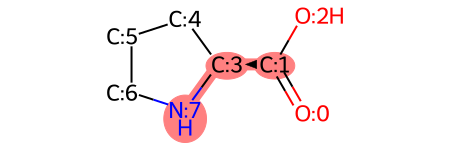

In [37]:
pmol=converter.templates['P'].mol
pmol

In [38]:
side_atoms = converter._collect_sidechain_atoms(
                pmol, 3, (7,3,1)
            )
print(side_atoms)

{3, 4, 5, 6}


In [13]:
#NOTE debug used
for i,residue in enumerate(residues):
    n_cap_atoms = _candidate_cap_atoms(
    mol,
    anchor=residues[i]["N"],
    avoid=residues[i]["CA"],
    backbone=residues,
    )
    print(i,residue, n_cap_atoms)
#locat ccap
for i,residue in enumerate(residues):
    c_cap_atoms = _candidate_cap_atoms(
    mol,
    anchor=residues[i]["C"],
    avoid=residues[i]["CA"],
    backbone=residues,
    )
    print(i,residue, c_cap_atoms)
        

0 {'N': 2, 'CA': 3, 'C': 4} {0, 1, 74}
1 {'N': 5, 'CA': 6, 'C': 7} set()
2 {'N': 8, 'CA': 9, 'C': 10} set()
0 {'N': 2, 'CA': 3, 'C': 4} set()
1 {'N': 5, 'CA': 6, 'C': 7} set()
2 {'N': 8, 'CA': 9, 'C': 10} {11}


In [15]:
# ------------------------- residue normalisation ------------------------ #

def _raw_residue_mol(
     fragmol: Chem.Mol, atoms_to_use: Set[int]
) -> Chem.Mol:
    """Prepare raw residue mol (remove dummies, keep existing substituents)."""
    smiles = Chem.MolFragmentToSmiles(
        fragmol, atomsToUse=sorted(atoms_to_use), isomericSmiles=True
    )
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Failed to parse fragment SMILES.")
    rw = Chem.RWMol(mol)
    for atom in rw.GetAtoms():
        if atom.GetAtomicNum() == 0:
            atom.SetAtomicNum(1)
            atom.SetFormalCharge(0)
        atom.SetAtomMapNum(0)
        atom.SetIsotope(0)
        atom.SetNoImplicit(False)
    mol = rw.GetMol()
    Chem.SanitizeMol(mol)
    return mol

def _alpha_cip(mol: Chem.Mol) -> Optional[str]:
    """Return CIP assignment for the residue's alpha carbon, if present."""
    Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
    matches = list(get_backbone_atoms(mol))
    if not matches:
        return None
    ca_idx = matches[0][1]
    atom = mol.GetAtomWithIdx(ca_idx)
    return atom.GetProp("_CIPCode") if atom.HasProp("_CIPCode") else None

def _copy_alpha_chirality(
    source: Chem.Mol, target: Chem.Mol
) -> None:
    """Copy the Cα chiral tag from source residue onto target residue."""
    src_matches = list(get_backbone_atoms(source))
    tgt_matches = list(get_backbone_atoms(target))
    if not src_matches or not tgt_matches:
        return
    src_ca = source.GetAtomWithIdx(src_matches[0][1])
    tgt_ca = target.GetAtomWithIdx(tgt_matches[0][1])
    tgt_ca.SetChiralTag(src_ca.GetChiralTag())
    Chem.AssignStereochemistry(target, force=True, cleanIt=True)

def _normalized_residue_mol(
    fragmol: Chem.Mol,
    atoms_to_use: Set[int],
    raw_reference: Optional[Chem.Mol] = None,
        ) -> Chem.Mol:
    """Build a residue molecule and normalise it to the acid form."""
    if not atoms_to_use:
        raise ValueError("Empty residue fragment encountered.")
    smiles = Chem.MolFragmentToSmiles(
        fragmol, atomsToUse=sorted(atoms_to_use), isomericSmiles=True
    )
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Failed to parse fragment SMILES.")
    rw = Chem.RWMol(mol)
    for atom in rw.GetAtoms():
        if atom.GetAtomicNum() == 0:  # RDKit dummy atom
            atom.SetAtomicNum(1)
            atom.SetFormalCharge(0)
        atom.SetAtomMapNum(0)
        atom.SetIsotope(0)
        atom.SetNoImplicit(False)

    # Convert cleavage hydrogens on carbonyl carbon back to hydroxyls.
    for atom in list(rw.GetAtoms()):
        if atom.GetAtomicNum() != 1:
            continue
        neighbors = atom.GetNeighbors()
        if len(neighbors) != 1:
            continue
        carbon = neighbors[0]
        if carbon.GetAtomicNum() != 6:
            continue
        is_carbonyl = False
        for bond in carbon.GetBonds():
            other = bond.GetOtherAtom(carbon)
            if (
                bond.GetBondType() == Chem.rdchem.BondType.DOUBLE
                and other.GetAtomicNum() == 8
            ):
                is_carbonyl = True
                break
        if not is_carbonyl:
            continue
        atom.SetAtomicNum(8)
        atom.SetFormalCharge(0)
        atom.SetNoImplicit(False)
        atom.SetNumExplicitHs(0)

    # For carbonyl carbons lacking a leaving group (after cleavage), add OH.
    carbonyl_candidates: List[int] = []
    for atom in rw.GetAtoms():
        if atom.GetAtomicNum() != 6:
            continue
        double_oxygens = [
            bond.GetOtherAtom(atom)
            for bond in atom.GetBonds()
            if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE
            and bond.GetOtherAtom(atom).GetAtomicNum() == 8
        ]
        if len(double_oxygens) != 1:
            continue
        single_neighbors = [
            bond.GetOtherAtom(atom)
            for bond in atom.GetBonds()
            if bond.GetBondType() == Chem.rdchem.BondType.SINGLE
        ]
        # If only one single neighbor (the alpha carbon), recreate hydroxyl
        if len(single_neighbors) == 1:
            carbonyl_candidates.append(atom.GetIdx())

    for idx in carbonyl_candidates:
        new_atom = Chem.Atom(8)
        new_atom.SetFormalCharge(0)
        o_idx = rw.AddAtom(new_atom)
        rw.AddBond(idx, o_idx, Chem.rdchem.BondType.SINGLE)

    mol = rw.GetMol()
    Chem.SanitizeMol(mol)
    mol = Chem.RemoveHs(mol)
    Chem.SanitizeMol(mol)
    if raw_reference is not None:
        _copy_alpha_chirality(raw_reference, mol)
    return mol    




In [25]:
for pos, residue in enumerate(residues, start=1):
    frag_idx = ca_to_fragment[residue["CA"]]
    atoms = set(atom_frags[frag_idx])
    print(pos, residue)
    # print(atoms)
    remove_n = (
        n_cap_atoms.copy() if pos == 1 and n_cap_atoms else set()
    )
    remove_c = (
        c_cap_atoms.copy()
        if pos == len(residues) and c_cap_atoms
        else set()
    )
    # print(remove_n,remove_c)
    #_match_single_residue
    res_atoms = atoms - remove_n - remove_c
    raw_mol = _raw_residue_mol(fragmol, res_atoms)#frag withou dummy
    rs_hint = _alpha_cip(raw_mol)
    mol_candidate = _normalized_residue_mol(
            fragmol, res_atoms, raw_reference=raw_mol  )
    # match = self._select_template_for_residue(
    #         mol_candidate, raw_mol, pos, rs_hint
    #     )   
    # canonical = Chem.MolToSmiles(mol_candidate, isomericSmiles=True)
    match = converter._select_template_for_residue(
            mol_candidate, raw_mol, pos, rs_hint
        )
    print(match)
    n_cap_used = bool(remove_n)
    c_cap_used = bool(remove_c)
    # print(n_cap_used,c_cap_used)

1 {'N': 2, 'CA': 3, 'C': 4}
ResidueMatch(index=1, code='K', canonical='CC(=O)N[C@@H](CCCCN)C(=O)O', ld='L', alternatives=['dK@1.00'], score=1.0, used_fallback=False, approximate=False, components=None)
2 {'N': 5, 'CA': 6, 'C': 7}
ResidueMatch(index=2, code='dR', canonical='N=C(N)NCCC[C@@H](N)C(=O)O', ld='D', alternatives=[], score=1.0, used_fallback=False, approximate=False, components=None)
3 {'N': 8, 'CA': 9, 'C': 10}
ResidueMatch(index=3, code='LyS_1PEG2_1PEG2_C12', canonical='CCCCCCCCCCCC(=O)N[C@@H](CCC(=O)NCCOCCOCC(=O)NCCOCCOCC(=O)NCCCC[C@H](N)C(=O)O)C(=O)O', ld='L', alternatives=[], score=1.0, used_fallback=False, approximate=False, components=['LyS', '1PEG2', '1PEG2', 'C12'])


In [ ]:
n_cap_used

ResidueMatch(index=3, code='LyS_1PEG2_1PEG2_C12', canonical='CCCCCCCCCCCC(=O)N[C@@H](CCC(=O)NCCOCCOCC(=O)NCCOCCOCC(=O)NCCCC[C@H](N)C(=O)O)C(=O)O', ld='L', alternatives=[], score=1.0, used_fallback=False, approximate=False, components=['LyS', '1PEG2', '1PEG2', 'C12'])

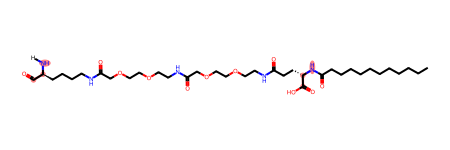

In [18]:
raw_mol

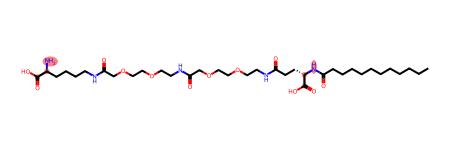

In [19]:
mol_candidate

In [40]:
from smi2seq import SMILES2Sequence